In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
cmap = cm.RdYlBu_r
from numpy import transpose as T
import torch
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from botorch import fit_gpytorch_model
from botorch.sampling.samplers import SobolQMCNormalSampler

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1tj0j318 because the default path (/home/f/Faran.Irshad/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
##############################-----------------------------------------------------##############################################

from opt import *

##############################-----------------------------------------------------##############################################

# Define dimensions for the optimization.

# Dimensions for 1-step MOMF (The output dimensions is always number of objectives +1 for the fidelity objective.)
dim_x=5
dim_y=3
ref_point=[0,0,0]
# Dimensions for 2-step MOMF
dim_y2=2
ref_point2=[0,0]
# Dimensions for MO
dim_xMO=4
dim_yMO=2
ref_pointMO=[0,0]
standard_boundsMO = torch.tensor([[0.0] * dim_xMO, [1.0] * dim_xMO], **tkwargs)


# The optimization ends if the total cost is reached or the iterations are done.
BATCH_SIZE = 1
n_TRIALS = 10     
n_BATCH = 150
cost_total=5000
n_INIT=5
n_INITMO=1

MC_SAMPLES = 128 
standard_bounds = torch.tensor([[0.0] * dim_x, [1.0] * dim_x], **tkwargs)

# The GPU-ID to use if present

gpu_number = 0

set_GPU(gpu_number)

verbose=True

Current GPU ID 1
New GPU ID 0


In [3]:

# Cost modelled as val=c+A*np.exp(B*s), the param has the parameters of this Cost function
param=[0.01,4.81,0]


In [4]:
# 1-Step MOMF

# Initializing input-output arrays
train_x=torch.zeros(n_INIT+n_BATCH,dim_x,n_TRIALS).to(**tkwargs)
train_obj=torch.zeros(n_INIT+n_BATCH,dim_y,n_TRIALS).to(**tkwargs)
# The number of iterations if the total cost is reached before total iterations
batch_count=np.zeros((n_TRIALS))

for trial in range(0, n_TRIALS):
    torch.manual_seed(trial)
    print('***************************************************************************')
    print('Trial is ',trial)

    # Generating Initial data and fitting a GP model.
    train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial] = generate_initial_data(dim_x,dim_y,n_INIT,0)  
    mll_qehvi, model_qehvi = initialize_model(train_x[:n_INIT,:,trial], train_obj[:n_INIT,:,trial])
    # Initializing the current cost and counts step for each trial
    cost=np.array([0.0])
    count=0


    print('Initial Data Generated\n')
    # Running the optimization for N_BATCH
    for iteration in range(0, n_BATCH ):    
            print('----------------------------')
            print('Iteration Number is ',iteration+1)
            
            # fit the models
            fit_gpytorch_model(mll_qehvi)
            # Sobol sampler for optimization of EHVI
            qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
                    
            # Optimize Acquisition function and get new observations
            try:
                new_x_qehvi,new_obj_qehvi= optimize_qehvi_and_get_observation_old(
                    model_qehvi, train_obj[:,:,trial], qehvi_sampler,dim_y,ref_point,standard_bounds,BATCH_SIZE, gpu_number
                    )
            except:
                print('Error in Optimize')
            # Updating Cost
            cost+=cfunc(1+new_x_qehvi[:,-1].detach().cpu().numpy(),*param,return_torch=False)
            print('Current Cost',cost)
            if (cost>cost_total):
                break
            count+=1
            # Updating Progress
            train_x[n_INIT+iteration,:,trial]=new_x_qehvi          
            train_obj[n_INIT+iteration,:,trial]=new_obj_qehvi
            
            
            # reinitialize the models so they are ready for fitting on next iteration
            mll_qehvi, model_qehvi = initialize_model(train_x[:iteration+1+n_INIT,:,trial], train_obj[:iteration+1+n_INIT,:,trial])
    np.save('X1step_costlim.npy',train_x.cpu().numpy())
    np.save('Y1step_costlim.npy',train_obj.cpu().numpy())        
    batch_count[trial]=count
    print('1-step MOMF Completed') 

***************************************************************************
Trial is  0
Sim Input [[0.87615293 0.5897688  0.68753335 0.86305722 0.22      ]
 [0.42496889 0.71902986 0.18270298 0.81457455 0.01      ]
 [0.93947393 0.01865943 0.46880311 0.35484848 0.1       ]
 [0.54798495 0.92798994 0.57811996 0.38272105 0.02      ]
 [0.63322968 0.84378803 0.20712924 0.70649967 0.        ]]
Sim Output tensor([[-0.1199,  0.1802,  0.1540],
        [-0.2425,  0.0592,  0.0070],
        [ 0.1495,  0.0477,  0.0700],
        [-0.5377,  0.1175,  0.0140],
        [-0.4048,  0.0960,  0.0000]], device='cuda:1', dtype=torch.float64)
Initial Data Generated

----------------------------
Iteration Number is  1
Sim Input [[0.8322956  0.37609384 0.69712457 0.6761358  0.05132831]]
Sim Output tensor([[-0.0088,  0.1564,  0.0359]], device='cuda:1', dtype=torch.float64)
Current Cost [1.57101044]
----------------------------
Iteration Number is  2
Sim Input [[0.76785694 0.39339945 0.87776638 0.9075629  0.05653159

Sim Input [[0.97020088 0.23136092 0.50014815 0.8969002  0.98390974]]
Sim Output tensor([[0.0751, 0.2881, 0.6887]], device='cuda:1', dtype=torch.float64)
Current Cost [1172.89954411]
----------------------------
Iteration Number is  35
Sim Input [[0.         0.         0.39338525 0.88560235 1.        ]]
Sim Output tensor([[0.2921, 0.1391, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [1323.53004349]
----------------------------
Iteration Number is  36
Sim Input [[0.97570391 0.0031785  0.21232414 0.87738841 0.8958924 ]]
Sim Output tensor([[0.1937, 0.1184, 0.6271]], device='cuda:1', dtype=torch.float64)
Current Cost [1414.82287252]
----------------------------
Iteration Number is  37
Sim Input [[0.02322714 0.03477742 0.73835988 0.3608243  0.43070026]]
Sim Output tensor([[ 0.2728, -0.1130,  0.3015]], device='cuda:1', dtype=torch.float64)
Current Cost [1424.56537531]
----------------------------
Iteration Number is  38
Sim Input [[0.24325482 0.12414421 0.53106818 0.86016725 0

Sim Input [[0.00965869 0.02385599 0.2179743  0.60898365 0.27742187]]
Sim Output tensor([[ 0.3188, -0.0559,  0.1942]], device='cuda:1', dtype=torch.float64)
Current Cost [4005.48119453]
----------------------------
Iteration Number is  70
Sim Input [[0.04659362 0.05074765 0.33864194 0.92570019 0.99677316]]
Sim Output tensor([[0.2574, 0.1383, 0.6977]], device='cuda:1', dtype=torch.float64)
Current Cost [4153.79179514]
----------------------------
Iteration Number is  71
Sim Input [[0.47847727 0.00128117 0.45506621 0.98925536 0.98731589]]
Sim Output tensor([[0.0638, 0.3334, 0.6911]], device='cuda:1', dtype=torch.float64)
Current Cost [4295.50697266]
----------------------------
Iteration Number is  72
Sim Input [[0.01364905 0.01289875 0.72832141 0.71130795 0.97044212]]
Sim Output tensor([[0.2946, 0.0755, 0.6793]], device='cuda:1', dtype=torch.float64)
Current Cost [4426.17453368]
----------------------------
Iteration Number is  73
Sim Input [[0.78995439 0.02006818 0.48401357 0.76988161 0

Sim Input [[0.         0.         0.         0.56984691 0.1228053 ]]
Sim Output tensor([[ 0.3606, -0.3454,  0.0860]], device='cuda:1', dtype=torch.float64)
Current Cost [780.2003947]
----------------------------
Iteration Number is  24
Sim Input [[0.         0.         0.23546297 0.7212316  0.19009422]]
Sim Output tensor([[ 0.3335, -0.0323,  0.1331]], device='cuda:1', dtype=torch.float64)
Current Cost [783.26274604]
----------------------------
Iteration Number is  25
Sim Input [[0.         0.         0.40056507 0.7013136  0.47371731]]
Sim Output tensor([[0.3071, 0.0878, 0.3316]], device='cuda:1', dtype=torch.float64)
Current Cost [795.2448004]
----------------------------
Iteration Number is  26
Sim Input [[0.         0.         1.         0.94213959 0.25672707]]
Sim Output tensor([[ 0.3571, -0.3237,  0.1797]], device='cuda:1', dtype=torch.float64)
Current Cost [799.46417551]
----------------------------
Iteration Number is  27
Sim Input [[0.         0.         0.16558012 0.70676335 0

Sim Input [[0.         0.         0.13475937 0.76554411 0.210964  ]]
Sim Output tensor([[ 0.3465, -0.1337,  0.1477]], device='cuda:1', dtype=torch.float64)
Current Cost [3110.15167491]
----------------------------
Iteration Number is  59
Sim Input [[0.13672389 0.01678988 0.54896724 0.72725858 0.97413071]]
Sim Output tensor([[0.2111, 0.2383, 0.6819]], device='cuda:1', dtype=torch.float64)
Current Cost [3243.15824519]
----------------------------
Iteration Number is  60
Sim Input [[0.8893358  0.04451085 0.56382451 0.87072442 0.93860467]]
Sim Output tensor([[0.1130, 0.3095, 0.6570]], device='cuda:1', dtype=torch.float64)
Current Cost [3355.27247511]
----------------------------
Iteration Number is  61
Sim Input [[0.99707349 0.09094713 0.54377544 0.50893291 0.99339588]]
Sim Output tensor([[0.1316, 0.2069, 0.6954]], device='cuda:1', dtype=torch.float64)
Current Cost [3501.19327609]
----------------------------
Iteration Number is  62
Sim Input [[0.03490939 0.12218536 0.61626815 0.76401678 1

Sim Input [[0.30827472 0.         0.52985485 0.79217797 0.78618154]]
Sim Output tensor([[0.1384, 0.3006, 0.5503]], device='cuda:1', dtype=torch.float64)
Current Cost [186.81424]
----------------------------
Iteration Number is  17
Sim Input [[0.04071871 0.         0.53163247 0.77452338 0.93037552]]
Sim Output tensor([[0.2705, 0.1821, 0.6513]], device='cuda:1', dtype=torch.float64)
Current Cost [294.57742396]
----------------------------
Iteration Number is  18
Sim Input [[0.18638093 0.         0.51471636 0.80704448 1.        ]]
Sim Output tensor([[0.1887, 0.2752, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [445.20792334]
----------------------------
Iteration Number is  19
Sim Input [[0.37543734 0.         0.49341097 0.83398679 1.        ]]
Sim Output tensor([[0.1006, 0.3471, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [595.83842273]
----------------------------
Iteration Number is  20
Sim Input [[0.         0.         0.54698798 0.74925    0.49284802]

Sim Input [[0.         0.         0.88761484 0.83712477 0.79429118]]
Sim Output tensor([[ 0.3296, -0.1190,  0.5560]], device='cuda:1', dtype=torch.float64)
Current Cost [2119.57790502]
----------------------------
Iteration Number is  52
Sim Input [[0.57663156 0.         0.49878261 0.79296945 1.        ]]
Sim Output tensor([[0.0578, 0.3783, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [2270.2084044]
----------------------------
Iteration Number is  53
Sim Input [[0.52655062 0.00688024 0.74096988 0.4578008  0.99249008]]
Sim Output tensor([[0.0550, 0.1654, 0.6947]], device='cuda:1', dtype=torch.float64)
Current Cost [2415.49482072]
----------------------------
Iteration Number is  54
Sim Input [[0.13419946 0.         0.51245468 0.7991239  1.        ]]
Sim Output tensor([[0.2169, 0.2480, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [2566.1253201]
----------------------------
Iteration Number is  55
Sim Input [[0.33797337 0.03305682 0.53812841 0.88020843 0.8

Sim Input [[0.1010816  0.29481772 0.86336597 0.83631305 0.0064508 ]]
Sim Output tensor([[ 0.2183, -0.0976,  0.0045]], device='cuda:1', dtype=torch.float64)
Current Cost [1.26599473]
----------------------------
Iteration Number is  2
Sim Input [[0.33494006 0.10667728 0.63672719 0.90333982 0.04036556]]
Sim Output tensor([[0.1261, 0.1840, 0.0283]], device='cuda:1', dtype=torch.float64)
Current Cost [2.75631071]
----------------------------
Iteration Number is  3
Sim Input [[0.53057543 0.12747467 0.99827719 0.83532608 0.01227196]]
Sim Output tensor([[ 0.1066, -0.2105,  0.0086]], device='cuda:1', dtype=torch.float64)
Current Cost [4.05825394]
----------------------------
Iteration Number is  4
Sim Input [[0.1913939  0.21230139 0.69357354 0.83924265 0.24451427]]
Sim Output tensor([[0.1569, 0.1304, 0.1712]], device='cuda:1', dtype=torch.float64)
Current Cost [8.03690742]
----------------------------
Iteration Number is  5
Sim Input [[0.27843094 0.19809373 0.6090655  0.69534945 0.21677013]]
S

Sim Input [[0.         0.         0.91546249 0.79642182 0.19454632]]
Sim Output tensor([[ 0.3529, -0.1992,  0.1362]], device='cuda:1', dtype=torch.float64)
Current Cost [1041.71129891]
----------------------------
Iteration Number is  37
Sim Input [[0.81602476 0.         0.4508853  0.79443555 0.68961188]]
Sim Output tensor([[0.1137, 0.3090, 0.4827]], device='cuda:1', dtype=torch.float64)
Current Cost [1075.5587249]
----------------------------
Iteration Number is  38
Sim Input [[0.60375499 0.06162748 0.48998949 0.77198918 0.92913591]]
Sim Output tensor([[0.0324, 0.3696, 0.6504]], device='cuda:1', dtype=torch.float64)
Current Cost [1182.68127898]
----------------------------
Iteration Number is  39
Sim Input [[1.         0.         0.3995048  0.28259055 0.08337513]]
Sim Output tensor([[ 0.1764, -0.0450,  0.0584]], device='cuda:1', dtype=torch.float64)
Current Cost [1184.51411441]
----------------------------
Iteration Number is  40
Sim Input [[0.17330046 0.00355206 0.34968937 0.6390918 

Sim Input [[0.01548934 0.04860648 0.52198536 0.80264424 0.15229713]]
Sim Output tensor([[0.2972, 0.0882, 0.1066]], device='cuda:1', dtype=torch.float64)
Current Cost [4764.97278992]
----------------------------
Iteration Number is  72
Sim Input [[0.02650962 0.23201457 0.56409283 0.62881663 1.        ]]
Sim Output tensor([[0.2097, 0.1523, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [4915.6032893]
----------------------------
Iteration Number is  73
Sim Input [[0.         0.         0.65732929 0.83279699 0.37236448]]
Sim Output tensor([[0.3164, 0.0617, 0.2607]], device='cuda:1', dtype=torch.float64)
Current Cost [4922.96213403]
----------------------------
Iteration Number is  74
Sim Input [[0.00666886 0.06135098 0.02576245 0.7866365  0.01372497]]
Sim Output tensor([[ 0.3491, -0.2885,  0.0096]], device='cuda:1', dtype=torch.float64)
Current Cost [4924.27320841]
----------------------------
Iteration Number is  75
Sim Input [[0.11582672 0.14094315 0.78122617 0.5737584  0.

Sim Input [[0.         0.         0.41271    0.84142416 0.68726239]]
Sim Output tensor([[0.3014, 0.1189, 0.4811]], device='cuda:1', dtype=torch.float64)
Current Cost [1240.10692143]
----------------------------
Iteration Number is  30
Sim Input [[0.84026985 0.12451642 0.56974782 0.88515316 0.99430805]]
Sim Output tensor([[0.0536, 0.3288, 0.6960]], device='cuda:1', dtype=torch.float64)
Current Cost [1386.66935876]
----------------------------
Iteration Number is  31
Sim Input [[0.11540781 0.02987009 0.52428323 0.63836484 0.99286834]]
Sim Output tensor([[0.2135, 0.2134, 0.6950]], device='cuda:1', dtype=torch.float64)
Current Cost [1532.22035616]
----------------------------
Iteration Number is  32
Sim Input [[0.61122806 0.06717777 0.49031947 0.70390002 0.97615145]]
Sim Output tensor([[0.0254, 0.3680, 0.6833]], device='cuda:1', dtype=torch.float64)
Current Cost [1666.52601915]
----------------------------
Iteration Number is  33
Sim Input [[0.31458327 0.0161067  0.5491705  0.86422128 0.96

Sim Input [[0.00701534 0.06926334 0.5311875  0.81924994 0.97173415]]
Sim Output tensor([[0.2712, 0.1646, 0.6802]], device='cuda:1', dtype=torch.float64)
Current Cost [5043.95278842]
1-step MOMF Completed
***************************************************************************
Trial is  5
Sim Input [[0.14844508 0.56914631 0.78882117 0.61496673 0.31      ]
 [0.39042521 0.76883823 0.61639904 0.48772693 0.69      ]
 [0.22792392 0.34212128 0.38435135 0.33107611 0.27      ]
 [0.67217087 0.56160301 0.62516419 0.35093191 0.08      ]
 [0.24452328 0.58122082 0.35907677 0.1365709  0.54      ]]
Sim Output tensor([[ 0.0385,  0.0160,  0.2170],
        [-0.3688,  0.2153,  0.4830],
        [ 0.0335,  0.0188,  0.1890],
        [-0.2252,  0.0845,  0.0560],
        [-0.1607, -0.1349,  0.3780]], device='cuda:1', dtype=torch.float64)
Initial Data Generated

----------------------------
Iteration Number is  1
Sim Input [[0.         0.         0.33233399 0.47483712 0.        ]]
Sim Output tensor([[ 0.3116

Sim Input [[0.9767566  0.00322552 0.47949635 0.63793665 0.67396027]]
Sim Output tensor([[0.1769, 0.2333, 0.4718]], device='cuda:1', dtype=torch.float64)
Current Cost [1123.8621888]
----------------------------
Iteration Number is  34
Sim Input [[0.90357435 0.06378166 0.5020757  0.85960363 0.78714518]]
Sim Output tensor([[0.1183, 0.2957, 0.5510]], device='cuda:1', dtype=torch.float64)
Current Cost [1177.97105988]
----------------------------
Iteration Number is  35
Sim Input [[0.43235321 0.00527735 0.42866308 0.90424975 0.91122197]]
Sim Output tensor([[0.0839, 0.3321, 0.6379]], device='cuda:1', dtype=torch.float64)
Current Cost [1276.24977803]
----------------------------
Iteration Number is  36
Sim Input [[0.46862872 0.1122536  0.53868758 0.9373229  0.78166361]]
Sim Output tensor([[0.0298, 0.3239, 0.5472]], device='cuda:1', dtype=torch.float64)
Current Cost [1328.95063839]
----------------------------
Iteration Number is  37
Sim Input [[0.02367248 0.5279278  0.56095388 0.81865685 0.985

Sim Input [[0.00721914 0.29826003 0.51043955 0.87187605 1.        ]]
Sim Output tensor([[0.2070, 0.1671, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [4835.25406529]
----------------------------
Iteration Number is  69
Sim Input [[0.96931429 0.26445529 0.30430599 0.94195137 0.99774949]]
Sim Output tensor([[0.0692, 0.2105, 0.6984]], device='cuda:1', dtype=torch.float64)
Current Cost [4984.26278671]
----------------------------
Iteration Number is  70
Sim Input [[0.26501093 0.1066797  0.33498974 0.79265053 1.        ]]
Sim Output tensor([[0.1163, 0.2609, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [5134.89328609]
1-step MOMF Completed
***************************************************************************
Trial is  6
Sim Input [[0.99131168 0.85738179 0.47200801 0.0684925  0.03      ]
 [0.65815405 0.53838825 0.59429008 0.03887762 0.02      ]
 [0.82658747 0.86346607 0.48326246 0.16133419 0.26      ]
 [0.64642901 0.06178529 0.95290174 0.41319728 0.19    

Sim Input [[0.99667439 0.04811822 0.36123532 0.77938204 0.81581449]]
Sim Output tensor([[0.1774, 0.2289, 0.5711]], device='cuda:1', dtype=torch.float64)
Current Cost [1110.40991292]
----------------------------
Iteration Number is  32
Sim Input [[0.94161467 0.12933545 0.5336857  0.9253164  0.98508418]]
Sim Output tensor([[0.0999, 0.2920, 0.6896]], device='cuda:1', dtype=torch.float64)
Current Cost [1250.61198231]
----------------------------
Iteration Number is  33
Sim Input [[0.         0.         0.57004569 0.779415   0.72586287]]
Sim Output tensor([[0.2996, 0.1281, 0.5081]], device='cuda:1', dtype=torch.float64)
Current Cost [1290.90709537]
----------------------------
Iteration Number is  34
Sim Input [[0.00177346 0.15311814 0.40947096 0.77668678 0.95691936]]
Sim Output tensor([[0.2564, 0.1487, 0.6698]], device='cuda:1', dtype=torch.float64)
Current Cost [1413.34596865]
----------------------------
Iteration Number is  35
Sim Input [[0.         0.         0.73329966 0.71725246 0.43

Sim Input [[0.70392764 0.0107459  0.49316352 0.93015776 0.92584892]]
Sim Output tensor([[0.0626, 0.3485, 0.6481]], device='cuda:1', dtype=torch.float64)
Current Cost [3496.50979551]
----------------------------
Iteration Number is  67
Sim Input [[0.         0.         0.15605546 0.77811404 0.31489769]]
Sim Output tensor([[ 0.3407, -0.0995,  0.2204]], device='cuda:1', dtype=torch.float64)
Current Cost [3502.0914639]
----------------------------
Iteration Number is  68
Sim Input [[0.5247436  0.04559752 0.63628266 0.863936   0.99436569]]
Sim Output tensor([[0.0471, 0.3353, 0.6961]], device='cuda:1', dtype=torch.float64)
Current Cost [3648.69453848]
----------------------------
Iteration Number is  69
Sim Input [[0.12612226 0.01256355 0.42352173 0.7749889  0.8176871 ]]
Sim Output tensor([[0.2262, 0.2136, 0.5724]], device='cuda:1', dtype=torch.float64)
Current Cost [3711.36591238]
----------------------------
Iteration Number is  70
Sim Input [[0.0786929  0.35203052 0.48566838 0.57386833 0.

Sim Input [[0.85887633 0.         0.52494858 0.80938555 0.68620262]]
Sim Output tensor([[0.1292, 0.2999, 0.4803]], device='cuda:1', dtype=torch.float64)
Current Cost [145.82015846]
----------------------------
Iteration Number is  20
Sim Input [[0.03405472 0.         0.56462205 0.71039101 0.55207109]]
Sim Output tensor([[0.2857, 0.1278, 0.3864]], device='cuda:1', dtype=torch.float64)
Current Cost [163.2867803]
----------------------------
Iteration Number is  21
Sim Input [[0.         0.         0.53807177 0.71404284 0.2291889 ]]
Sim Output tensor([[0.3119, 0.0782, 0.1604]], device='cuda:1', dtype=torch.float64)
Current Cost [166.98269628]
----------------------------
Iteration Number is  22
Sim Input [[0.08104923 0.         0.51749877 0.75366642 0.786392  ]]
Sim Output tensor([[0.2530, 0.1922, 0.5505]], device='cuda:1', dtype=torch.float64)
Current Cost [220.89589481]
----------------------------
Iteration Number is  23
Sim Input [[0.48447456 0.         0.507546   0.82024321 0.5247431

Sim Input [[0.73339482 0.06913374 0.32421341 0.83271101 0.9991022 ]]
Sim Output tensor([[0.0515, 0.3067, 0.6994]], device='cuda:1', dtype=torch.float64)
Current Cost [3044.77907515]
----------------------------
Iteration Number is  55
Sim Input [[0.04614943 0.08091837 0.07148614 0.81762551 0.12617473]]
Sim Output tensor([[ 0.3151, -0.2006,  0.0883]], device='cuda:1', dtype=torch.float64)
Current Cost [3047.030876]
----------------------------
Iteration Number is  56
Sim Input [[0.56444505 0.02242465 0.47679884 0.69900358 0.95772066]]
Sim Output tensor([[0.0486, 0.3631, 0.6704]], device='cuda:1', dtype=torch.float64)
Current Cost [3169.94257457]
----------------------------
Iteration Number is  57
Sim Input [[0.03774977 0.20553572 0.51715459 0.52850697 0.99509849]]
Sim Output tensor([[0.1995, 0.1264, 0.6966]], device='cuda:1', dtype=torch.float64)
Current Cost [3317.06330475]
----------------------------
Iteration Number is  58
Sim Input [[0.80858234 0.13233468 0.11799387 0.65516296 0.9

Sim Input [[0.         0.01968203 0.4663111  0.8002683  0.28955003]]
Sim Output tensor([[0.3073, 0.0908, 0.2027]], device='cuda:1', dtype=torch.float64)
Current Cost [35.48222702]
----------------------------
Iteration Number is  13
Sim Input [[0.02214876 0.13314964 0.39100166 0.8143645  0.61817689]]
Sim Output tensor([[0.2620, 0.1225, 0.4327]], device='cuda:1', dtype=torch.float64)
Current Cost [59.4871913]
----------------------------
Iteration Number is  14
Sim Input [[0.         0.01521311 0.318072   0.96649668 0.18717962]]
Sim Output tensor([[0.3169, 0.0109, 0.1310]], device='cuda:1', dtype=torch.float64)
Current Cost [62.50691028]
----------------------------
Iteration Number is  15
Sim Input [[0.0069673  0.32265572 0.48035268 0.97763264 0.4696472 ]]
Sim Output tensor([[0.2155, 0.0915, 0.3288]], device='cuda:1', dtype=torch.float64)
Current Cost [74.25667089]
----------------------------
Iteration Number is  16
Sim Input [[0.         0.02633891 0.40463062 0.54125802 0.59317359]]


Sim Input [[0.6395647  0.01582831 0.43012436 0.74706309 0.83015224]]
Sim Output tensor([[0.0618, 0.3455, 0.5811]], device='cuda:1', dtype=torch.float64)
Current Cost [2179.80349579]
----------------------------
Iteration Number is  48
Sim Input [[0.11823266 0.07967989 0.53838859 0.96106514 0.96445832]]
Sim Output tensor([[0.1984, 0.2112, 0.6751]], device='cuda:1', dtype=torch.float64)
Current Cost [2306.76378077]
----------------------------
Iteration Number is  49
Sim Input [[0.         0.         0.16419094 0.8517015  0.53212787]]
Sim Output tensor([[ 0.3325, -0.0741,  0.3725]], device='cuda:1', dtype=torch.float64)
Current Cost [2322.63273899]
----------------------------
Iteration Number is  50
Sim Input [[0.38780434 0.         0.49967578 0.8225011  1.        ]]
Sim Output tensor([[0.0962, 0.3510, 0.7000]], device='cuda:1', dtype=torch.float64)
Current Cost [2473.26323838]
----------------------------
Iteration Number is  51
Sim Input [[0.02639548 0.0507851  0.43051206 0.91253387 0

Sim Input [[0.83979282 0.05165371 0.18394687 0.9431407  0.02207269]]
Sim Output tensor([[0.1589, 0.0315, 0.0155]], device='cuda:1', dtype=torch.float64)
Current Cost [4.05695749]
----------------------------
Iteration Number is  4
Sim Input [[0.55845583 0.         0.         1.         0.        ]]
Sim Output tensor([[ 0.1580, -0.2310,  0.0000]], device='cuda:1', dtype=torch.float64)
Current Cost [5.28427367]
----------------------------
Iteration Number is  5
Sim Input [[0.9522757  0.11094549 0.32910227 0.99402113 0.21234487]]
Sim Output tensor([[0.1557, 0.1357, 0.1486]], device='cuda:1', dtype=torch.float64)
Current Cost [8.69255661]
----------------------------
Iteration Number is  6
Sim Input [[0.82267444 0.12101314 0.38597652 0.86889626 0.27786512]]
Sim Output tensor([[0.0898, 0.2370, 0.1945]], device='cuda:1', dtype=torch.float64)
Current Cost [13.36349993]
----------------------------
Iteration Number is  7
Sim Input [[1.         0.13881725 0.48652271 0.90032881 0.24010037]]
Sim

Sim Input [[0.07227939 0.00213666 0.39006444 0.70716048 0.92908102]]
Sim Output tensor([[0.2549, 0.1767, 0.6504]], device='cuda:1', dtype=torch.float64)
Current Cost [1522.79456212]
----------------------------
Iteration Number is  39
Sim Input [[0.00328346 0.0440112  0.68672647 0.60763497 0.64921483]]
Sim Output tensor([[0.2933, 0.0459, 0.4545]], device='cuda:1', dtype=torch.float64)
Current Cost [1550.66462683]
----------------------------
Iteration Number is  40
Sim Input [[4.65374632e-01 5.56084859e-04 6.10999216e-01 8.70112481e-01
  7.56673183e-01]]
Sim Output tensor([[0.0889, 0.3110, 0.5297]], device='cuda:1', dtype=torch.float64)
Current Cost [1597.39656476]
----------------------------
Iteration Number is  41
Sim Input [[0.30070725 0.07901179 0.47872747 0.8525517  0.91130706]]
Sim Output tensor([[0.1044, 0.3117, 0.6379]], device='cuda:1', dtype=torch.float64)
Current Cost [1695.71551464]
----------------------------
Iteration Number is  42
Sim Input [[0.28422352 0.05194984 0.46

In [5]:
np.save('X1step_costlim.npy',train_x.cpu().numpy())
np.save('Y1step_costlim.npy',train_obj.cpu().numpy())  

In [6]:
batch_count

array([78., 74., 81., 74., 63., 69., 78., 74., 75., 69.])

In [7]:
# 2-step MOMF

# Initializing input-output arrays
# The MF array tracks the summation of the objectives and is used to fit a model that helps MF-MES select the fidelity in the
# 2nd step
train_x2_step=torch.zeros(n_INIT+n_BATCH,dim_x,n_TRIALS).to(**tkwargs)
train_obj2_step=torch.zeros(n_INIT+n_BATCH,dim_y2,n_TRIALS).to(**tkwargs)
train_objMF=torch.zeros(n_INIT+n_BATCH,1,n_TRIALS).to(**tkwargs)

# The number of iterations if the total cost is reached before total iterations
batch_count2_step=np.zeros((n_TRIALS))

for trial in range(0, n_TRIALS):
    torch.manual_seed(trial)
    print('***************************************************************************')
    print('Trial is ',trial)
    
    
    # Generating Initial data and fitting a GP model.
    train_x2_step[:n_INIT,:,trial], train_obj2_step[:n_INIT,:,trial] = generate_initial_data_2step(dim_x,dim_y2,n_INIT,0)  
    train_objMF[:n_INIT,:,trial]=(train_obj2_step[:n_INIT,0,trial]+train_obj2_step[:n_INIT,1,trial]).reshape(-1,1)
    mll_qehvi_2_step, model_qehvi_2_step = initialize_model(train_x2_step[:n_INIT,:,trial],train_objMF[:n_INIT,:,trial] )
    mll_qehviMO, model_qehviMO = initialize_model(train_x2_step[:n_INIT,:,trial], train_obj2_step[:n_INIT,:,trial])
    # Initializing the current cost and counts step for each trial
    cost2_step=np.array([0.0])
    count2_step=0
    
    
    
    print('Initial Data Generated\n')
    # Running the optimization for N_BATCH
    for iteration in range(0, n_BATCH ):    
            print('----------------------------')
            print('Iteration Number is ',iteration+1)
            # fit the models
            fit_gpytorch_model(mll_qehvi_2_step)
            fit_gpytorch_model(mll_qehviMO)

            qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
            candidate_set = torch.rand(1000, standard_bounds.size(1), device=standard_bounds.device, dtype=standard_bounds.dtype)
            candidate_set = standard_bounds[0] + (standard_bounds[1] - standard_bounds[0]) * candidate_set
        # Optimize Acquisition function and get new observations
            
            # Optimizes to yield the input x.
            try:
                
                suggested_x= optimize_qehvi_and_get_observation_2step(
                    model_qehviMO, train_obj2_step[:,:,trial], qehvi_sampler,dim_y2,ref_point2,standard_bounds,BATCH_SIZE, gpu_number
                    )
            # The fidelity is appended to the suggested x from the EHVI and used to make new observations.
                new_x_qehvi,new_obj_qehviMF,new_obj_qehvi=optimize_qMFMES_and_get_observation(model_qehvi_2_step,suggested_x,dim_y2,candidate_set,
                                                                              standard_bounds,BATCH_SIZE,gpu_number)
            except:
                print('Error in Optimize')
            print('MF',new_obj_qehviMF)
            print('MO',new_obj_qehvi)
            
            # Updating Cost
            cost2_step+=cfunc(1+new_x_qehvi[:,-1].detach().cpu().numpy(),*param,return_torch=False)
            print('Current Cost',cost2_step)
            if (cost2_step>cost_total):
                break
            count2_step+=1
            
            # Updating Progress
            train_x2_step[n_INIT+iteration,:,trial]=new_x_qehvi
            train_obj2_step[n_INIT+iteration,:,trial]=new_obj_qehvi
            train_objMF[n_INIT+iteration,:,trial]=new_obj_qehviMF
            
        

            # Reinitialize the models so they are ready for fitting on next iteration
            mll_qehvi_2_step, model_qehvi_2_step = initialize_model(train_x2_step[:iteration+1+n_INIT,:,trial], train_objMF[:iteration+1+n_INIT,:,trial])
            mll_qehviMO, model_qehviMO = initialize_model(train_x2_step[:iteration+1+n_INIT,:,trial], train_obj2_step[:iteration+1+n_INIT,:,trial])
    np.save('X2step_costlim.npy',train_x2_step.cpu().numpy())
    np.save('Y2step_costlim.npy',train_obj2_step.cpu().numpy())
    batch_count2_step[trial]=count2_step
    print('2-step MOMF Completed')     

***************************************************************************
Trial is  0
Sim Input [[0.00749638 0.10887829 0.13919971 0.73837742 0.06      ]
 [0.01093952 0.57593593 0.4678736  0.78932617 0.36      ]
 [0.91192936 0.54846617 0.39882979 0.93033573 0.14      ]
 [0.69070056 0.79638842 0.45560722 0.35150632 0.        ]
 [0.51524129 0.17701725 0.45037069 0.35643023 0.02      ]]
Sim Output tensor([[ 0.3235, -0.1362],
        [ 0.1388,  0.1101],
        [-0.0725,  0.1937],
        [-0.4050,  0.0967],
        [ 0.0043,  0.0986]], device='cuda:1', dtype=torch.float64)
Initial Data Generated

----------------------------
Iteration Number is  1
Suggested X tensor([[0.0000, 0.5419, 0.4573, 0.8085]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.54185289 0.45728713 0.80850335 0.        ]]
Sim Output tensor([[0.1773, 0.0655]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.2428]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1773, 0.0655]], device='cu

Suggested X tensor([[0.0198, 0.0000, 0.4850, 0.8131]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.01977347 0.         0.48499843 0.81307027 1.        ]]
Sim Output tensor([[0.2794, 0.1769]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4563]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2794, 0.1769]], device='cuda:1', dtype=torch.float64)
Current Cost [794.44348798]
----------------------------
Iteration Number is  19
Suggested X tensor([[0.1301, 0.0000, 0.4817, 0.8132]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.13014302 0.         0.48166587 0.81315321 0.58181858]]
Sim Output tensor([[0.2345, 0.1997]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4343]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2345, 0.1997]], device='cuda:1', dtype=torch.float64)
Current Cost [814.59697209]
----------------------------
Iteration Number is  20
Suggested X tensor([[0.1276, 0.0000, 0.4966, 0.8089]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[0.0000, 0.0000, 0.4903, 0.8028]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.49031647 0.80276838 0.00166701]]
Sim Output tensor([[0.3194, 0.0634]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3828]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.3194, 0.0634]], device='cuda:1', dtype=torch.float64)
Current Cost [1755.74146237]
----------------------------
Iteration Number is  37
Suggested X tensor([[0.0000, 0.0000, 0.9369, 0.6463]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.93689674 0.64628748 0.99997317]]
Sim Output tensor([[ 0.3238, -0.1883]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.1355]], device='cuda:1', dtype=torch.float64)
MO tensor([[ 0.3238, -0.1883]], device='cuda:1', dtype=torch.float64)
Current Cost [1906.35252548]
----------------------------
Iteration Number is  38
Suggested X tensor([[0.0000, 0.0000, 0.5172, 0.7985]], device='cuda:1',
       dtype=t

Suggested X tensor([[0.0000, 0.0000, 0.0530, 0.5741]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.05295178 0.57405803 0.0014392 ]]
Sim Output tensor([[ 0.3588, -0.2807]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.0781]], device='cuda:1', dtype=torch.float64)
MO tensor([[ 0.3588, -0.2807]], device='cuda:1', dtype=torch.float64)
Current Cost [2930.96389803]
----------------------------
Iteration Number is  55
Suggested X tensor([[0.5935, 0.0533, 0.5010, 0.7892]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[5.93527029e-01 5.33016206e-02 5.00977082e-01 7.89151122e-01
  4.31875698e-04]]
Sim Output tensor([[0.0878, 0.2570]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3449]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0878, 0.2570]], device='cuda:1', dtype=torch.float64)
Current Cost [2932.19376638]
----------------------------
Iteration Number is  56
Suggested X tensor([[0.5928, 0.0532, 0.5008, 0.7885]], device='c

Suggested X tensor([[0.1446, 0.0000, 0.5036, 0.7996]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.14460286 0.         0.5036228  0.79961243 1.        ]]
Sim Output tensor([[0.2111, 0.2539]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4651]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2111, 0.2539]], device='cuda:1', dtype=torch.float64)
Current Cost [4593.73872927]
----------------------------
Iteration Number is  73
Suggested X tensor([[0.7134, 0.0000, 0.5033, 0.7946]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.71344547 0.         0.50327903 0.7945554  0.99888463]]
Sim Output tensor([[0.0689, 0.3707]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4396]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0689, 0.3707]], device='cuda:1', dtype=torch.float64)
Current Cost [4743.56327213]
----------------------------
Iteration Number is  74
Suggested X tensor([[0.8322, 0.0000, 0.5051, 0.7899]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.0190, 0.0166, 0.4796, 0.8995]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.01896203 0.01655762 0.47957547 0.89946112 0.0018353 ]]
Sim Output tensor([[0.3053, 0.0671]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3724]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.3053, 0.0671]], device='cuda:1', dtype=torch.float64)
Current Cost [385.25081069]
----------------------------
Iteration Number is  12
Suggested X tensor([[0.0704, 0.0000, 0.4797, 0.8897]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.07043486 0.         0.47965616 0.88968014 0.45444627]]
Sim Output tensor([[0.2688, 0.1459]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4146]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2688, 0.1459]], device='cuda:1', dtype=torch.float64)
Current Cost [396.17212562]
----------------------------
Iteration Number is  13
Suggested X tensor([[0.1464, 0.0325, 0.4730, 0.8632]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[0.3259, 0.0000, 0.4907, 0.7822]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.32590901 0.         0.49071934 0.78221055 1.        ]]
Sim Output tensor([[0.1205, 0.3328]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4533]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1205, 0.3328]], device='cuda:1', dtype=torch.float64)
Current Cost [1688.9641952]
----------------------------
Iteration Number is  30
Suggested X tensor([[0.2147, 0.0000, 0.4888, 0.7921]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.21465218 0.         0.48877674 0.79212644 1.        ]]
Sim Output tensor([[0.1738, 0.2889]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4626]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1738, 0.2889]], device='cuda:1', dtype=torch.float64)
Current Cost [1839.59469458]
----------------------------
Iteration Number is  31
Suggested X tensor([[1.0000, 0.0000, 0.5033, 0.9360]], device='cuda:1',
       dtype=torch.

Sim Input [[0.43122814 0.         0.48856513 0.79559988 0.99968716]]
Sim Output tensor([[0.0825, 0.3611]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4436]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0825, 0.3611]], device='cuda:1', dtype=torch.float64)
Current Cost [3143.22081341]
----------------------------
Iteration Number is  48
Suggested X tensor([[0.1118, 0.0000, 0.4942, 0.8011]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.11181906 0.         0.49419524 0.80111936 1.        ]]
Sim Output tensor([[0.2291, 0.2355]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4646]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2291, 0.2355]], device='cuda:1', dtype=torch.float64)
Current Cost [3293.85131279]
----------------------------
Iteration Number is  49
Suggested X tensor([[0.5892, 0.0626, 0.4851, 0.7989]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[5.89165688e-01 6.26079787e-02 4.85091309e-01 7.98870569e-01
  2.33731233e-04]]

Sim Input [[0.60162493 0.         0.5012441  0.77641304 0.00193785]]
Sim Output tensor([[0.1100, 0.2565]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3665]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1100, 0.2565]], device='cuda:1', dtype=torch.float64)
Current Cost [4477.48312546]
----------------------------
Iteration Number is  66
Suggested X tensor([[0.6016, 0.0000, 0.5014, 0.7771]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.60161414 0.         0.50143909 0.77705268 0.00174328]]
Sim Output tensor([[0.1100, 0.2565]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3665]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1100, 0.2565]], device='cuda:1', dtype=torch.float64)
Current Cost [4478.72077616]
----------------------------
Iteration Number is  67
Suggested X tensor([[0.6014, 0.0000, 0.5008, 0.7773]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.60135766 0.         0.50084724 0.77727544 0.99999982]]
Sim Output tensor([[0

Suggested X tensor([[0.0935, 0.1309, 0.4931, 0.7173]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.0934581  0.13094572 0.49307312 0.71731452 0.        ]]
Sim Output tensor([[0.2385, 0.1139]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3525]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2385, 0.1139]], device='cuda:1', dtype=torch.float64)
Current Cost [72.6621499]
----------------------------
Iteration Number is  8
Suggested X tensor([[0.1732, 0.0849, 0.4919, 0.7723]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.17320494 0.08491303 0.49190071 0.7722677  0.17969835]]
Sim Output tensor([[0.2020, 0.1780]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3799]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2020, 0.1780]], device='cuda:1', dtype=torch.float64)
Current Cost [75.57513653]
----------------------------
Iteration Number is  9
Suggested X tensor([[0.2168, 0.0514, 0.4943, 0.8133]], device='cuda:1',
       dtype=torch.float6

Suggested X tensor([[0.0000, 0.0000, 0.4757, 0.7986]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.47572341 0.79857121 0.90065365]]
Sim Output tensor([[0.2930, 0.1528]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4458]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2930, 0.1528]], device='cuda:1', dtype=torch.float64)
Current Cost [698.21680541]
----------------------------
Iteration Number is  26
Suggested X tensor([[0.1028, 0.0000, 0.4898, 0.8027]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.10279018 0.         0.48975207 0.80267413 0.95000692]]
Sim Output tensor([[0.2359, 0.2247]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4606]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2359, 0.2247]], device='cuda:1', dtype=torch.float64)
Current Cost [816.651663]
----------------------------
Iteration Number is  27
Suggested X tensor([[0.2954, 0.0000, 0.4940, 0.7980]], device='cuda:1',
       dtype=torch.flo

Sim Input [[0.12115829 0.         0.50411944 0.79267064 1.        ]]
Sim Output tensor([[0.2240, 0.2408]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4648]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2240, 0.2408]], device='cuda:1', dtype=torch.float64)
Current Cost [2366.31913513]
----------------------------
Iteration Number is  44
Suggested X tensor([[1.0000, 0.0000, 0.4939, 0.8647]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[1.00000000e+00 0.00000000e+00 4.93937148e-01 8.64673759e-01
  5.86697832e-04]]
Sim Output tensor([[0.2211, 0.1667]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3878]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2211, 0.1667]], device='cuda:1', dtype=torch.float64)
Current Cost [2367.54991971]
----------------------------
Iteration Number is  45
Suggested X tensor([[1.0000, 0.0000, 0.5346, 0.7628]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[1.         0.         0.53463779 0.76278441 0.37617645]]

Sim Input [[0.60370117 0.03384425 0.49839041 0.78103542 0.99876597]]
Sim Output tensor([[0.0417, 0.3784]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4202]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0417, 0.3784]], device='cuda:1', dtype=torch.float64)
Current Cost [3995.74762889]
----------------------------
Iteration Number is  62
Suggested X tensor([[0.9656, 0.0000, 0.5025, 0.7975]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.96561136 0.         0.50246715 0.79748063 1.        ]]
Sim Output tensor([[0.1636, 0.2980]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4616]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1636, 0.2980]], device='cuda:1', dtype=torch.float64)
Current Cost [4146.37812827]
----------------------------
Iteration Number is  63
Suggested X tensor([[0.0000, 0.0000, 0.6481, 0.7939]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.        0.        0.648148  0.7938683 1.       ]]
Sim Output tensor([[0.2970

Suggested X tensor([[0.0198, 0.1567, 0.4302, 0.5469]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.0198117  0.15669324 0.43021024 0.54686702 0.62809618]]
Sim Output tensor([[0.2423, 0.0801]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3225]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2423, 0.0801]], device='cuda:1', dtype=torch.float64)
Current Cost [34.26659118]
----------------------------
Iteration Number is  7
Suggested X tensor([[0.0000, 0.0835, 0.6047, 0.6574]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.08352107 0.60472025 0.65739373 0.00118996]]
Sim Output tensor([[0.3024, 0.0327]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3351]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.3024, 0.0327]], device='cuda:1', dtype=torch.float64)
Current Cost [35.5009523]
----------------------------
Iteration Number is  8
Suggested X tensor([[0.0000, 0.0776, 0.5877, 0.6556]], device='cuda:1',
       dtype=torch.float6

Sim Input [[0.16876142 0.         0.50266224 0.85360308 0.41712035]]
Sim Output tensor([[0.2202, 0.1997]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4199]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2202, 0.1997]], device='cuda:1', dtype=torch.float64)
Current Cost [363.05658249]
----------------------------
Iteration Number is  25
Suggested X tensor([[0.1679, 0.0000, 0.5021, 0.8527]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.16789829 0.         0.50214327 0.85273012 0.62222352]]
Sim Output tensor([[0.2127, 0.2220]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4347]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2127, 0.2220]], device='cuda:1', dtype=torch.float64)
Current Cost [387.53336312]
----------------------------
Iteration Number is  26
Suggested X tensor([[0.1983, 0.0000, 0.5056, 0.8444]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.19828058 0.         0.50564713 0.84439126 0.78165371]]
Sim Output tensor([[0.1

Suggested X tensor([[0.4221, 0.0000, 0.4963, 0.8009]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.422142   0.         0.49625741 0.80094599 0.00104683]]
Sim Output tensor([[0.1351, 0.2396]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3747]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1351, 0.2396]], device='cuda:1', dtype=torch.float64)
Current Cost [2503.88850293]
----------------------------
Iteration Number is  44
Suggested X tensor([[0.1246, 0.0000, 0.5012, 0.8053]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.12458335 0.         0.50117214 0.8052672  1.        ]]
Sim Output tensor([[0.2221, 0.2428]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4649]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2221, 0.2428]], device='cuda:1', dtype=torch.float64)
Current Cost [2654.51900232]
----------------------------
Iteration Number is  45
Suggested X tensor([[0.4221, 0.0000, 0.4966, 0.8016]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.6088, 0.0000, 0.4811, 0.8021]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[6.08811566e-01 0.00000000e+00 4.81099865e-01 8.02137991e-01
  3.15187499e-04]]
Sim Output tensor([[0.1103, 0.2561]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3664]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1103, 0.2561]], device='cuda:1', dtype=torch.float64)
Current Cost [3773.32244623]
----------------------------
Iteration Number is  62
Suggested X tensor([[0.6087, 0.0000, 0.4828, 0.8017]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.60868729 0.         0.48275838 0.8017357  0.99928848]]
Sim Output tensor([[0.0575, 0.3779]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4355]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0575, 0.3779]], device='cuda:1', dtype=torch.float64)
Current Cost [3923.43830644]
----------------------------
Iteration Number is  63
Suggested X tensor([[0.1881, 0.0000, 0.5011, 0.8031]], device='cuda:

Suggested X tensor([[0.3086, 0.0829, 0.2864, 0.8940]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.308621   0.08293064 0.28639869 0.89401978 0.20544482]]
Sim Output tensor([[0.1469, 0.1474]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.2942]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1469, 0.1474]], device='cuda:1', dtype=torch.float64)
Current Cost [16.69853819]
----------------------------
Iteration Number is  5
Suggested X tensor([[0.2734, 0.0085, 0.3151, 0.8753]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.2733957  0.00851253 0.31512781 0.87532711 0.        ]]
Sim Output tensor([[0.1958, 0.1364]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3322]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1958, 0.1364]], device='cuda:1', dtype=torch.float64)
Current Cost [17.92585437]
----------------------------
Iteration Number is  6
Suggested X tensor([[0.2342, 0.0279, 0.3498, 0.9341]], device='cuda:1',
       dtype=torch.float

Suggested X tensor([[0.1391, 0.0000, 0.4334, 0.8157]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.13908712 0.         0.43341143 0.8157279  0.19631261]]
Sim Output tensor([[0.2455, 0.1559]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4014]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2455, 0.1559]], device='cuda:1', dtype=torch.float64)
Current Cost [156.95253609]
----------------------------
Iteration Number is  23
Suggested X tensor([[0.5341, 0.0000, 0.4270, 0.8227]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.53410252 0.         0.42700734 0.82266845 0.59178505]]
Sim Output tensor([[0.0845, 0.3160]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4005]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0845, 0.3160]], device='cuda:1', dtype=torch.float64)
Current Cost [178.09568413]
----------------------------
Iteration Number is  24
Suggested X tensor([[0.5408, 0.0000, 0.4271, 0.8242]], device='cuda:1',
       dtype=torch.f

Sim Input [[0.16874496 0.         0.4757736  0.8160237  1.        ]]
Sim Output tensor([[0.1982, 0.2655]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4637]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1982, 0.2655]], device='cuda:1', dtype=torch.float64)
Current Cost [1786.31403851]
----------------------------
Iteration Number is  41
Suggested X tensor([[0.4192, 0.0000, 0.4822, 0.8145]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[4.19167861e-01 0.00000000e+00 4.82246164e-01 8.14514935e-01
  4.26610000e-04]]
Sim Output tensor([[0.1360, 0.2383]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3743]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1360, 0.2383]], device='cuda:1', dtype=torch.float64)
Current Cost [1787.54387571]
----------------------------
Iteration Number is  42
Suggested X tensor([[0.0264, 0.0000, 0.4817, 0.8177]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.02643582 0.         0.48174027 0.81773216 1.        ]]

Sim Input [[4.65945209e-01 0.00000000e+00 4.83870120e-01 8.05399685e-01
  7.73924403e-04]]
Sim Output tensor([[0.1246, 0.2466]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3712]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1246, 0.2466]], device='cuda:1', dtype=torch.float64)
Current Cost [3152.50321881]
----------------------------
Iteration Number is  59
Suggested X tensor([[0.4660, 0.0000, 0.4842, 0.8051]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.46602885 0.         0.48418935 0.8051216  0.9986042 ]]
Sim Output tensor([[0.0734, 0.3671]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4406]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0734, 0.3671]], device='cuda:1', dtype=torch.float64)
Current Cost [3302.12580594]
----------------------------
Iteration Number is  60
Suggested X tensor([[0.3818, 0.0000, 0.4855, 0.8010]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.38180091 0.         0.48549565 0.80100977 0.99961613]]

Sim Input [[0.59831979 0.         0.4932567  0.79054449 0.99859364]]
Sim Output tensor([[0.0574, 0.3783]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4357]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0574, 0.3783]], device='cuda:1', dtype=torch.float64)
Current Cost [4559.55434793]
----------------------------
Iteration Number is  77
Suggested X tensor([[0.5911, 0.0528, 0.4889, 0.7819]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.59112629 0.05279089 0.48889594 0.78189071 0.99929824]]
Sim Output tensor([[0.0328, 0.3784]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4113]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0328, 0.3784]], device='cuda:1', dtype=torch.float64)
Current Cost [4709.67725914]
----------------------------
Iteration Number is  78
Suggested X tensor([[0.9352, 0.0000, 0.4849, 0.7817]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.93515635 0.         0.48490624 0.78168341 1.        ]]
Sim Output tensor([[0

Suggested X tensor([[0.3355, 0.0000, 0.5021, 0.8368]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.33553492 0.         0.50206026 0.83684169 0.        ]]
Sim Output tensor([[0.1632, 0.2176]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3808]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1632, 0.2176]], device='cuda:1', dtype=torch.float64)
Current Cost [69.00610241]
----------------------------
Iteration Number is  14
Suggested X tensor([[0.3405, 0.0000, 0.5042, 0.8341]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.34052809 0.         0.50418355 0.83410391 0.70017142]]
Sim Output tensor([[0.1284, 0.3015]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4299]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1284, 0.3015]], device='cuda:1', dtype=torch.float64)
Current Cost [104.61709427]
----------------------------
Iteration Number is  15
Suggested X tensor([[0.0000, 0.0000, 0.4811, 0.6887]], device='cuda:1',
       dtype=torch.fl

Suggested X tensor([[0.8452, 0.0000, 0.5121, 0.8109]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.84523136 0.         0.51210752 0.81093174 1.        ]]
Sim Output tensor([[0.1087, 0.3419]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4506]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1087, 0.3419]], device='cuda:1', dtype=torch.float64)
Current Cost [1560.7747202]
----------------------------
Iteration Number is  32
Suggested X tensor([[0.1936, 0.0000, 0.4824, 0.7980]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.19357562 0.         0.48240153 0.79802123 1.        ]]
Sim Output tensor([[0.1849, 0.2786]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4635]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1849, 0.2786]], device='cuda:1', dtype=torch.float64)
Current Cost [1711.40521959]
----------------------------
Iteration Number is  33
Suggested X tensor([[0.6049, 0.0195, 0.5045, 0.7911]], device='cuda:1',
       dtype=torch.

Suggested X tensor([[0.6074, 0.0539, 0.4998, 0.8005]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[6.07351157e-01 5.39296656e-02 4.99809097e-01 8.00539964e-01
  9.38624144e-05]]
Sim Output tensor([[0.0876, 0.2571]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3447]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0876, 0.2571]], device='cuda:1', dtype=torch.float64)
Current Cost [3074.10033563]
----------------------------
Iteration Number is  50
Suggested X tensor([[0.1570, 0.0000, 0.4847, 0.7954]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.15701129 0.         0.48470139 0.79535665 1.        ]]
Sim Output tensor([[0.2045, 0.2602]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4646]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2045, 0.2602]], device='cuda:1', dtype=torch.float64)
Current Cost [3224.73083502]
----------------------------
Iteration Number is  51
Suggested X tensor([[0.0608, 0.0000, 0.4905, 0.7975]], device='cuda:

Suggested X tensor([[0.6097, 0.0000, 0.4716, 0.7814]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.60966527 0.         0.47162174 0.78135425 0.9995242 ]]
Sim Output tensor([[0.0576, 0.3767]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4343]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0576, 0.3767]], device='cuda:1', dtype=torch.float64)
Current Cost [4883.57255839]
----------------------------
Iteration Number is  68
Suggested X tensor([[0.7278, 0.0000, 0.5028, 0.8045]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.72779509 0.         0.5028316  0.80451653 0.99897103]]
Sim Output tensor([[0.0719, 0.3686]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4405]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0719, 0.3686]], device='cuda:1', dtype=torch.float64)
Current Cost [5033.45937867]
2-step MOMF Completed
***************************************************************************
Trial is  6
Sim Input [[0.12787807 0.17451347

Suggested X tensor([[0.2343, 0.0000, 0.5109, 0.8566]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.23427616 0.         0.51091242 0.85663084 0.52718554]]
Sim Output tensor([[0.1831, 0.2412]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4243]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1831, 0.2412]], device='cuda:1', dtype=torch.float64)
Current Cost [108.90352459]
----------------------------
Iteration Number is  17
Suggested X tensor([[0.3119, 0.0000, 0.5022, 0.8603]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.31190636 0.         0.50224031 0.86031681 0.39566016]]
Sim Output tensor([[0.1538, 0.2548]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4086]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1538, 0.2548]], device='cuda:1', dtype=torch.float64)
Current Cost [117.13491679]
----------------------------
Iteration Number is  18
Suggested X tensor([[0.3497, 0.0000, 0.5049, 0.8664]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[0.0000, 0.0000, 0.8579, 0.5396]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.00000000e+00 0.00000000e+00 8.57901008e-01 5.39649704e-01
  6.16142526e-04]]
Sim Output tensor([[ 0.3445, -0.1810]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.1635]], device='cuda:1', dtype=torch.float64)
MO tensor([[ 0.3445, -0.1810]], device='cuda:1', dtype=torch.float64)
Current Cost [1520.78750429]
----------------------------
Iteration Number is  35
Suggested X tensor([[0.0000, 0.0000, 0.5481, 0.7998]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.        0.        0.548127  0.7997791 1.       ]]
Sim Output tensor([[0.2906, 0.1600]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4507]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2906, 0.1600]], device='cuda:1', dtype=torch.float64)
Current Cost [1671.41800368]
----------------------------
Iteration Number is  36
Suggested X tensor([[0.3527, 0.0000, 0.5086, 0.7941]], device='cuda:1

Suggested X tensor([[0.4413, 0.0000, 0.4954, 0.8042]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[4.41314235e-01 0.00000000e+00 4.95395816e-01 8.04158433e-01
  7.69015402e-04]]
Sim Output tensor([[0.1301, 0.2431]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3732]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1301, 0.2431]], device='cuda:1', dtype=torch.float64)
Current Cost [2772.37407056]
----------------------------
Iteration Number is  53
Suggested X tensor([[0.0000, 0.0000, 0.8630, 0.7155]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.86303643 0.715521   0.99892948]]
Sim Output tensor([[ 0.3195, -0.0741]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.2453]], device='cuda:1', dtype=torch.float64)
MO tensor([[ 0.3195, -0.0741]], device='cuda:1', dtype=torch.float64)
Current Cost [2922.23093543]
----------------------------
Iteration Number is  54
Suggested X tensor([[0.4415, 0.0000, 0.4964, 0.8035]], device='c

Suggested X tensor([[0.1661, 0.0000, 0.4998, 0.7964]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.16613753 0.         0.49982008 0.79641141 1.        ]]
Sim Output tensor([[0.1994, 0.2654]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4648]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1994, 0.2654]], device='cuda:1', dtype=torch.float64)
Current Cost [4283.39893335]
----------------------------
Iteration Number is  71
Suggested X tensor([[0.8189, 0.0000, 0.5109, 0.8105]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[8.18858726e-01 0.00000000e+00 5.10914043e-01 8.10465449e-01
  5.88846393e-04]]
Sim Output tensor([[0.1474, 0.2304]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3778]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1474, 0.2304]], device='cuda:1', dtype=torch.float64)
Current Cost [4284.62973064]
----------------------------
Iteration Number is  72
Suggested X tensor([[0.8189, 0.0000, 0.5110, 0.8106]], device='cuda:

Suggested X tensor([[0.2316, 0.0000, 0.6240, 0.7106]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.23156995 0.         0.62400801 0.71061146 0.        ]]
Sim Output tensor([[0.2109, 0.1517]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3627]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2109, 0.1517]], device='cuda:1', dtype=torch.float64)
Current Cost [191.98817908]
----------------------------
Iteration Number is  10
Suggested X tensor([[0.2234, 0.0000, 0.5991, 0.7431]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.22339334 0.         0.59913035 0.74310492 0.54143078]]
Sim Output tensor([[0.1911, 0.2215]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4126]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1911, 0.2215]], device='cuda:1', dtype=torch.float64)
Current Cost [208.58335184]
----------------------------
Iteration Number is  11
Suggested X tensor([[0.1567, 0.0000, 0.4350, 0.8520]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[0.2078, 0.0000, 0.5245, 0.8397]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.20775947 0.         0.52449293 0.83966802 0.97169227]]
Sim Output tensor([[0.1784, 0.2803]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4587]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1784, 0.2803]], device='cuda:1', dtype=torch.float64)
Current Cost [812.61120457]
----------------------------
Iteration Number is  28
Suggested X tensor([[0.0000, 0.0000, 0.5121, 0.8449]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.         0.         0.51211152 0.84491531 1.        ]]
Sim Output tensor([[0.2895, 0.1617]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4512]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2895, 0.1617]], device='cuda:1', dtype=torch.float64)
Current Cost [963.24170395]
----------------------------
Iteration Number is  29
Suggested X tensor([[0.0000, 0.0000, 0.6910, 0.7037]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[1.0000, 0.0000, 0.5302, 0.5946]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[1.         0.         0.53021903 0.59459933 0.06444748]]
Sim Output tensor([[0.2123, 0.1425]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3548]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2123, 0.1425]], device='cuda:1', dtype=torch.float64)
Current Cost [2313.87049458]
----------------------------
Iteration Number is  46
Suggested X tensor([[0.8509, 0.0000, 0.5248, 0.8289]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.85092081 0.         0.52483765 0.82888916 1.        ]]
Sim Output tensor([[0.1110, 0.3387]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4497]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1110, 0.3387]], device='cuda:1', dtype=torch.float64)
Current Cost [2464.50099396]
----------------------------
Iteration Number is  47
Suggested X tensor([[0.2329, 0.0000, 0.5076, 0.8031]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.0614, 0.0000, 0.4984, 0.7999]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[6.14297942e-02 0.00000000e+00 4.98367403e-01 7.99922932e-01
  3.07292677e-04]]
Sim Output tensor([[0.2896, 0.1004]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3900]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2896, 0.1004]], device='cuda:1', dtype=torch.float64)
Current Cost [3381.25252792]
----------------------------
Iteration Number is  64
Suggested X tensor([[0.0533, 0.0000, 0.4993, 0.8137]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.05332943 0.         0.49931799 0.81368212 0.00165087]]
Sim Output tensor([[0.2935, 0.0957]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3892]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2935, 0.0957]], device='cuda:1', dtype=torch.float64)
Current Cost [3382.48962864]
----------------------------
Iteration Number is  65
Suggested X tensor([[0.0000, 0.0000, 0.2722, 0.8257]], device='cuda:

Suggested X tensor([[0.9466, 0.0000, 0.5099, 0.8124]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.94664745 0.         0.50986724 0.81242681 0.99835788]]
Sim Output tensor([[0.1542, 0.3057]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4598]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1542, 0.3057]], device='cuda:1', dtype=torch.float64)
Current Cost [4742.79508545]
----------------------------
Iteration Number is  82
Suggested X tensor([[0.6074, 0.0000, 0.4965, 0.7807]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[6.07444059e-01 0.00000000e+00 4.96540706e-01 7.80721917e-01
  3.58212739e-04]]
Sim Output tensor([[0.1101, 0.2564]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3665]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1101, 0.2564]], device='cuda:1', dtype=torch.float64)
Current Cost [4744.02451811]
----------------------------
Iteration Number is  83
Suggested X tensor([[0.3271, 0.0000, 0.5040, 0.8044]], device='cuda:

Suggested X tensor([[0.0320, 0.1798, 0.3411, 0.8857]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.03202921 0.17977744 0.34106069 0.88570769 0.40883293]]
Sim Output tensor([[0.2542, 0.0811]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3354]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2542, 0.0811]], device='cuda:1', dtype=torch.float64)
Current Cost [55.82015563]
----------------------------
Iteration Number is  9
Suggested X tensor([[0.1480, 0.0229, 0.4221, 0.7829]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.14796069 0.02288292 0.42211056 0.78292367 0.00183939]]
Sim Output tensor([[0.2426, 0.1368]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3794]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2426, 0.1368]], device='cuda:1', dtype=torch.float64)
Current Cost [57.05837862]
----------------------------
Iteration Number is  10
Suggested X tensor([[0.2731, 0.0000, 0.4431, 0.7852]], device='cuda:1',
       dtype=torch.floa

Suggested X tensor([[0.5455, 0.0228, 0.4979, 0.8236]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.54554043 0.02276653 0.49791186 0.82362927 0.99827487]]
Sim Output tensor([[0.0496, 0.3763]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4259]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0496, 0.3763]], device='cuda:1', dtype=torch.float64)
Current Cost [1266.21190785]
----------------------------
Iteration Number is  27
Suggested X tensor([[0.0636, 0.0000, 0.4974, 0.8069]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.06359165 0.         0.49741768 0.80688971 1.        ]]
Sim Output tensor([[0.2555, 0.2062]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4617]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2555, 0.2062]], device='cuda:1', dtype=torch.float64)
Current Cost [1416.84240723]
----------------------------
Iteration Number is  28
Suggested X tensor([[1.0000, 0.0000, 0.4521, 0.9698]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.6131, 0.0000, 0.5062, 0.7872]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.61310021 0.         0.50622315 0.7871591  0.00081088]]
Sim Output tensor([[0.1102, 0.2565]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3668]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1102, 0.2565]], device='cuda:1', dtype=torch.float64)
Current Cost [2211.41264591]
----------------------------
Iteration Number is  45
Suggested X tensor([[0.6130, 0.0000, 0.5063, 0.7870]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.61300733 0.         0.50625807 0.78702866 0.99989373]]
Sim Output tensor([[0.0575, 0.3783]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4358]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.0575, 0.3783]], device='cuda:1', dtype=torch.float64)
Current Cost [2361.96616857]
----------------------------
Iteration Number is  46
Suggested X tensor([[0.9052, 0.0000, 0.5033, 0.7995]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.0921, 0.0000, 0.4904, 0.8032]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.09205451 0.         0.49036807 0.80321447 1.        ]]
Sim Output tensor([[0.2400, 0.2237]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4637]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2400, 0.2237]], device='cuda:1', dtype=torch.float64)
Current Cost [3577.31815805]
----------------------------
Iteration Number is  63
Suggested X tensor([[0.0429, 0.0000, 0.4883, 0.8037]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.04294456 0.         0.4882971  0.80370898 0.99972608]]
Sim Output tensor([[0.2669, 0.1927]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4595]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.2669, 0.1927]], device='cuda:1', dtype=torch.float64)
Current Cost [3727.75032369]
----------------------------
Iteration Number is  64
Suggested X tensor([[0.7152, 0.0000, 0.5043, 0.8009]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.7005, 0.3013, 0.5309, 0.5883]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.70051902 0.3012859  0.53090575 0.58833862 0.        ]]
Sim Output tensor([[-0.0295,  0.2167]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.1872]], device='cuda:1', dtype=torch.float64)
MO tensor([[-0.0295,  0.2167]], device='cuda:1', dtype=torch.float64)
Current Cost [1.22731618]
----------------------------
Iteration Number is  2
Suggested X tensor([[0.6970, 0.2454, 0.5578, 0.6068]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.69696381 0.24543543 0.55783115 0.60682576 0.29726833]]
Sim Output tensor([[-0.0182,  0.2535]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.2353]], device='cuda:1', dtype=torch.float64)
MO tensor([[-0.0182,  0.2535]], device='cuda:1', dtype=torch.float64)
Current Cost [6.35518675]
----------------------------
Iteration Number is  3
Suggested X tensor([[0.6952, 0.1240, 0.6186, 0.6264]], device='cuda:1',
       dtype=torch

Suggested X tensor([[0.8823, 0.0000, 0.4908, 0.7707]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.88229107 0.         0.49084041 0.77069404 0.70627677]]
Sim Output tensor([[0.1376, 0.2952]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4327]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1376, 0.2952]], device='cuda:1', dtype=torch.float64)
Current Cost [550.39982934]
----------------------------
Iteration Number is  20
Suggested X tensor([[0.8711, 0.0000, 0.4986, 0.7659]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.87106072 0.         0.49856081 0.76591631 1.        ]]
Sim Output tensor([[0.1190, 0.3333]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4522]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1190, 0.3333]], device='cuda:1', dtype=torch.float64)
Current Cost [701.03032872]
----------------------------
Iteration Number is  21
Suggested X tensor([[0.6845, 0.0000, 0.5025, 0.7664]], device='cuda:1',
       dtype=torch.f

Suggested X tensor([[0.8172, 0.0000, 0.5034, 0.7781]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.81716524 0.         0.50344934 0.77809347 0.87648945]]
Sim Output tensor([[0.1041, 0.3349]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4390]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1041, 0.3349]], device='cuda:1', dtype=torch.float64)
Current Cost [1930.6368066]
----------------------------
Iteration Number is  38
Suggested X tensor([[0.1791, 0.0000, 0.5223, 0.7736]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.17914557 0.         0.52232899 0.77360193 0.92306715]]
Sim Output tensor([[0.1955, 0.2620]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.4575]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1955, 0.2620]], device='cuda:1', dtype=torch.float64)
Current Cost [2034.67757073]
----------------------------
Iteration Number is  39
Suggested X tensor([[0.3914, 0.0000, 0.5165, 0.7638]], device='cuda:1',
       dtype=torch.

Suggested X tensor([[0.5985, 0.0000, 0.4935, 0.8013]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.59850259 0.         0.49352053 0.80133632 0.00163367]]
Sim Output tensor([[0.1101, 0.2568]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3669]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1101, 0.2568]], device='cuda:1', dtype=torch.float64)
Current Cost [3908.94672402]
----------------------------
Iteration Number is  56
Suggested X tensor([[0.5986, 0.0000, 0.4935, 0.8012]], device='cuda:1',
       dtype=torch.float64)
Sim Input [[0.59856824 0.         0.49352267 0.80120517 0.00111382]]
Sim Output tensor([[0.1101, 0.2568]], device='cuda:1', dtype=torch.float64)
MF tensor([[0.3669]], device='cuda:1', dtype=torch.float64)
MO tensor([[0.1101, 0.2568]], device='cuda:1', dtype=torch.float64)
Current Cost [3910.18063313]
----------------------------
Iteration Number is  57
Suggested X tensor([[0.5984, 0.0000, 0.4938, 0.8013]], device='cuda:1',
       dtype=torch

In [8]:
batch_count2_step

array([77., 74., 71., 73., 79., 67., 77., 89., 78., 71.])

In [9]:
# MO example run

# Initializing input-output arrays
train_xMO=torch.zeros(n_INITMO+n_BATCH,dim_xMO,n_TRIALS).to(**tkwargs)
train_objMO=torch.zeros(n_INITMO+n_BATCH,dim_yMO,n_TRIALS).to(**tkwargs)

# The number of iterations if the total cost is reached before total iterations
batch_countMO=np.zeros((n_TRIALS))


for trial in range(0, n_TRIALS):
    torch.manual_seed(trial)
    print('***************************************************************************')
    print('Trial is ',trial)
    
    
        
    # Generating Initial data and fitting a GP model.
    train_xMO[:n_INITMO,:,trial], train_objMO[:n_INITMO,:,trial] = generate_initial_data_MO(dim_xMO,dim_yMO,n_INITMO,gpu_number)
    mll_qehviMO, model_qehviMO = initialize_model(train_xMO[:n_INITMO,:,trial], train_objMO[:n_INITMO,:,trial])
    # Initializing the current cost and counts step for each trial
    costMO=np.array([0.0])
    countMO=0
    print('Initial Data Generated\n')
    
    # Running the optimization for N_BATCH
    for iteration in range(0, 60 ): 
            print('----------------------------')
            print('Iteration Number is ',iteration+1)
        
            # fit the models
            fit_gpytorch_model(mll_qehviMO)
            # Sobol sampler for optimization of EHVI
            qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)
                    
            # Optimize Acquisition function and get new observations
            try:
                
                new_x_qehviMO,new_obj_qehviMO= optimize_qehvi_and_get_observation_MO(
                    model_qehviMO, train_objMO[:,:,trial], qehvi_sampler,dim_yMO,ref_pointMO,standard_boundsMO,BATCH_SIZE, gpu_number
                    )
            except:
                print('Error in Optimize')
            # Updating Cost
            costMO+=cfunc(1+np.array([1]),*param,return_torch=False)
            print('Current Cost',costMO)
            #if (costMO>cost_total):
            #    break
            countMO+=1
            # Updating Progress
            train_xMO[n_INITMO+iteration,:,trial]=new_x_qehviMO
            train_objMO[n_INITMO+iteration,:,trial]=new_obj_qehviMO
            
            # Reinitialize the models so they are ready for fitting on next iteration
            mll_qehviMO, model_qehviMO = initialize_model(train_xMO[:iteration+1+n_INITMO,:,trial], train_objMO[:iteration+1+n_INITMO,:,trial])
    np.save('XMO_costlim.npy',train_xMO.cpu().numpy())
    np.save('YMO_costlim.npy',train_objMO.cpu().numpy())
    batch_countMO[trial]=countMO
    print('MO Completed')

***************************************************************************
Trial is  0
Sim Input [[0.05812088 0.26150546 0.36667248 0.83709631 1.        ]]
Sim Output MO tensor([[0.1888, 0.1743]], device='cuda:1', dtype=torch.float64)
Initial Data Generated

----------------------------
Iteration Number is  1
Sim Input [[1. 1. 1. 0. 1.]]
Sim Output MO tensor([[-0.3845, -0.5006]], device='cuda:1', dtype=torch.float64)
Current Cost [150.63049938]
----------------------------
Iteration Number is  2
Sim Input [[0.         0.0545317  0.16545856 1.         1.        ]]
Sim Output MO tensor([[ 0.2990, -0.0598]], device='cuda:1', dtype=torch.float64)
Current Cost [301.26099877]
----------------------------
Iteration Number is  3
Sim Input [[0.         0.40919163 0.24401647 1.         1.        ]]
Sim Output MO tensor([[0.1899, 0.0257]], device='cuda:1', dtype=torch.float64)
Current Cost [451.89149815]
----------------------------
Iteration Number is  4
Sim Input [[0.         0.14930503 0.4652

Sim Input [[0.01777876 0.         0.49926488 0.80615592 1.        ]]
Sim Output MO tensor([[0.2804, 0.1760]], device='cuda:1', dtype=torch.float64)
Current Cost [5422.69797783]
----------------------------
Iteration Number is  37
Sim Input [[0.05514827 0.         0.49699265 0.80294918 1.        ]]
Sim Output MO tensor([[0.2602, 0.2008]], device='cuda:1', dtype=torch.float64)
Current Cost [5573.32847721]
----------------------------
Iteration Number is  38
Sim Input [[0.         0.         0.78300478 0.79246583 1.        ]]
Sim Output MO tensor([[0.3117, 0.0253]], device='cuda:1', dtype=torch.float64)
Current Cost [5723.95897659]
----------------------------
Iteration Number is  39
Sim Input [[1.         0.         0.42739912 0.73858117 1.        ]]
Sim Output MO tensor([[0.1824, 0.2696]], device='cuda:1', dtype=torch.float64)
Current Cost [5874.58947598]
----------------------------
Iteration Number is  40
Sim Input [[0.88846795 0.         0.4946262  0.79405444 1.        ]]
Sim Output 

Sim Input [[1.         0.         0.28577428 0.84489426 1.        ]]
Sim Output MO tensor([[0.1949, 0.1950]], device='cuda:1', dtype=torch.float64)
Current Cost [1656.93549322]
----------------------------
Iteration Number is  12
Sim Input [[1.         0.         0.         0.80182448 1.        ]]
Sim Output MO tensor([[ 0.2204, -0.2012]], device='cuda:1', dtype=torch.float64)
Current Cost [1807.56599261]
----------------------------
Iteration Number is  13
Sim Input [[0.90354048 0.         0.45644157 0.83700475 1.        ]]
Sim Output MO tensor([[0.1339, 0.3184]], device='cuda:1', dtype=torch.float64)
Current Cost [1958.19649199]
----------------------------
Iteration Number is  14
Sim Input [[0.78319584 0.         0.51336529 0.80222351 1.        ]]
Sim Output MO tensor([[0.0868, 0.3580]], device='cuda:1', dtype=torch.float64)
Current Cost [2108.82699138]
----------------------------
Iteration Number is  15
Sim Input [[0.19557219 0.         0.501281   0.8269102  1.        ]]
Sim Outpu

Sim Input [[0.06646379 0.         0.49968758 0.79782576 1.        ]]
Sim Output MO tensor([[0.2540, 0.2081]], device='cuda:1', dtype=torch.float64)
Current Cost [7079.63347105]
----------------------------
Iteration Number is  48
Sim Input [[0.         0.         0.27158742 0.72483612 1.        ]]
Sim Output MO tensor([[0.3043, 0.0711]], device='cuda:1', dtype=torch.float64)
Current Cost [7230.26397043]
----------------------------
Iteration Number is  49
Sim Input [[0.15152337 0.         0.4981858  0.79626126 1.        ]]
Sim Output MO tensor([[0.2074, 0.2577]], device='cuda:1', dtype=torch.float64)
Current Cost [7380.89446982]
----------------------------
Iteration Number is  50
Sim Input [[0.         0.         0.75848148 0.76725715 1.        ]]
Sim Output MO tensor([[0.3087, 0.0486]], device='cuda:1', dtype=torch.float64)
Current Cost [7531.5249692]
----------------------------
Iteration Number is  51
Sim Input [[0.39488705 0.         0.50084341 0.79800645 1.        ]]
Sim Output M

Sim Input [[0.         0.         0.90627205 0.79555208 1.        ]]
Sim Output MO tensor([[ 0.3242, -0.1296]], device='cuda:1', dtype=torch.float64)
Current Cost [3313.87098645]
----------------------------
Iteration Number is  23
Sim Input [[0.         0.         0.73527405 0.78686979 1.        ]]
Sim Output MO tensor([[0.3061, 0.0698]], device='cuda:1', dtype=torch.float64)
Current Cost [3464.50148583]
----------------------------
Iteration Number is  24
Sim Input [[0.71053816 0.         0.48904286 0.81225434 1.        ]]
Sim Output MO tensor([[0.0683, 0.3709]], device='cuda:1', dtype=torch.float64)
Current Cost [3615.13198522]
----------------------------
Iteration Number is  25
Sim Input [[1.         0.227359   0.47001489 0.8109896  1.        ]]
Sim Output MO tensor([[0.0977, 0.2826]], device='cuda:1', dtype=torch.float64)
Current Cost [3765.7624846]
----------------------------
Iteration Number is  26
Sim Input [[1.         0.         0.57716015 0.74369249 1.        ]]
Sim Output

Sim Input [[0.1599113  0.         0.49867059 0.7956838  1.        ]]
Sim Output MO tensor([[0.2028, 0.2621]], device='cuda:1', dtype=torch.float64)
Current Cost [8736.56896427]
----------------------------
Iteration Number is  59
Sim Input [[0.68059643 0.         0.50131733 0.7997913  1.        ]]
Sim Output MO tensor([[0.0632, 0.3747]], device='cuda:1', dtype=torch.float64)
Current Cost [8887.19946366]
----------------------------
Iteration Number is  60
Sim Input [[0.60183384 0.05072477 0.4995453  0.80800062 1.        ]]
Sim Output MO tensor([[0.0337, 0.3790]], device='cuda:1', dtype=torch.float64)
Current Cost [9037.82996304]
MO Completed
***************************************************************************
Trial is  3
Sim Input [[0.8283361  0.46840445 0.85842668 0.03729018 1.        ]]
Sim Output MO tensor([[-0.1954, -0.3026]], device='cuda:1', dtype=torch.float64)
Initial Data Generated

----------------------------
Iteration Number is  1
Sim Input [[0. 0. 0. 1. 1.]]
Sim Out

Sim Input [[0.83023587 0.         0.49287866 0.79898263 1.        ]]
Sim Output MO tensor([[0.1029, 0.3465]], device='cuda:1', dtype=torch.float64)
Current Cost [4970.80647967]
----------------------------
Iteration Number is  34
Sim Input [[1.         0.         0.47517899 0.76142934 1.        ]]
Sim Output MO tensor([[0.1813, 0.2799]], device='cuda:1', dtype=torch.float64)
Current Cost [5121.43697906]
----------------------------
Iteration Number is  35
Sim Input [[0.         0.         1.         0.89481877 1.        ]]
Sim Output MO tensor([[ 0.3283, -0.2767]], device='cuda:1', dtype=torch.float64)
Current Cost [5272.06747844]
----------------------------
Iteration Number is  36
Sim Input [[0.61421709 0.         0.49214508 0.80446317 1.        ]]
Sim Output MO tensor([[0.0575, 0.3784]], device='cuda:1', dtype=torch.float64)
Current Cost [5422.69797783]
----------------------------
Iteration Number is  37
Sim Input [[0.01677819 0.         0.46974614 0.78932303 1.        ]]
Sim Outpu

Sim Input [[0.16420474 0.         0.55653942 0.78812311 1.        ]]
Sim Output MO tensor([[0.2016, 0.2587]], device='cuda:1', dtype=torch.float64)
Current Cost [1205.04399507]
----------------------------
Iteration Number is  9
Sim Input [[0.         0.         0.3880416  0.79957249 1.        ]]
Sim Output MO tensor([[0.2940, 0.1435]], device='cuda:1', dtype=torch.float64)
Current Cost [1355.67449446]
----------------------------
Iteration Number is  10
Sim Input [[0.         0.         0.45708029 0.55696191 1.        ]]
Sim Output MO tensor([[0.2781, 0.1095]], device='cuda:1', dtype=torch.float64)
Current Cost [1506.30499384]
----------------------------
Iteration Number is  11
Sim Input [[0.26081107 0.01973577 0.52109258 0.82628332 1.        ]]
Sim Output MO tensor([[0.1433, 0.3080]], device='cuda:1', dtype=torch.float64)
Current Cost [1656.93549322]
----------------------------
Iteration Number is  12
Sim Input [[0.         0.         0.84039987 0.81326276 1.        ]]
Sim Output M

Sim Input [[1.         0.         0.68362998 0.         1.        ]]
Sim Output MO tensor([[ 0.0667, -0.3046]], device='cuda:1', dtype=torch.float64)
Current Cost [6627.7419729]
----------------------------
Iteration Number is  45
Sim Input [[0.         0.         0.07410988 0.78351113 1.        ]]
Sim Output MO tensor([[ 0.3255, -0.1586]], device='cuda:1', dtype=torch.float64)
Current Cost [6778.37247228]
----------------------------
Iteration Number is  46
Sim Input [[0.60259559 0.05418016 0.50680711 0.8146491  1.        ]]
Sim Output MO tensor([[0.0321, 0.3788]], device='cuda:1', dtype=torch.float64)
Current Cost [6929.00297167]
----------------------------
Iteration Number is  47
Sim Input [[0.60724078 0.         0.51060009 0.80439766 1.        ]]
Sim Output MO tensor([[0.0574, 0.3784]], device='cuda:1', dtype=torch.float64)
Current Cost [7079.63347105]
----------------------------
Iteration Number is  48
Sim Input [[0.31253051 0.         0.50214887 0.79566125 1.        ]]
Sim Outp

Sim Input [[1.         0.         0.39130158 0.89344364 1.        ]]
Sim Output MO tensor([[0.1835, 0.2536]], device='cuda:1', dtype=torch.float64)
Current Cost [2861.9794883]
----------------------------
Iteration Number is  20
Sim Input [[1.         0.         0.40970825 0.56684444 1.        ]]
Sim Output MO tensor([[0.1729, 0.2211]], device='cuda:1', dtype=torch.float64)
Current Cost [3012.60998768]
----------------------------
Iteration Number is  21
Sim Input [[0.2625937  0.         0.47174872 0.79166591 1.        ]]
Sim Output MO tensor([[0.1498, 0.3085]], device='cuda:1', dtype=torch.float64)
Current Cost [3163.24048706]
----------------------------
Iteration Number is  22
Sim Input [[1.         0.         0.56568816 0.84006811 1.        ]]
Sim Output MO tensor([[0.1825, 0.2732]], device='cuda:1', dtype=torch.float64)
Current Cost [3313.87098645]
----------------------------
Iteration Number is  23
Sim Input [[0. 0. 0. 0. 1.]]
Sim Output MO tensor([[ 0.2892, -0.5776]], device='c

Sim Input [[0.88694414 0.         0.50152956 0.80591574 1.        ]]
Sim Output MO tensor([[0.1261, 0.3289]], device='cuda:1', dtype=torch.float64)
Current Cost [8284.67746612]
----------------------------
Iteration Number is  56
Sim Input [[0.69694949 0.11069087 0.46685336 0.73414577 1.        ]]
Sim Output MO tensor([[0.0132, 0.3680]], device='cuda:1', dtype=torch.float64)
Current Cost [8435.30796551]
----------------------------
Iteration Number is  57
Sim Input [[0.60419704 0.03587425 0.49792408 0.79082751 1.        ]]
Sim Output MO tensor([[0.0408, 0.3788]], device='cuda:1', dtype=torch.float64)
Current Cost [8585.93846489]
----------------------------
Iteration Number is  58
Sim Input [[0.94500016 0.         0.50171896 0.80960315 1.        ]]
Sim Output MO tensor([[0.1533, 0.3068]], device='cuda:1', dtype=torch.float64)
Current Cost [8736.56896427]
----------------------------
Iteration Number is  59
Sim Input [[0.2735152  0.90559654 0.77967901 0.10129638 1.        ]]
Sim Output 

Sim Input [[0.27896308 0.         0.50344857 0.78950414 1.        ]]
Sim Output MO tensor([[0.1417, 0.3163]], device='cuda:1', dtype=torch.float64)
Current Cost [4518.91498152]
----------------------------
Iteration Number is  31
Sim Input [[0.         0.         0.36843908 0.74332448 1.        ]]
Sim Output MO tensor([[0.2949, 0.1328]], device='cuda:1', dtype=torch.float64)
Current Cost [4669.54548091]
----------------------------
Iteration Number is  32
Sim Input [[1.         0.66147341 0.49929028 0.98139954 1.        ]]
Sim Output MO tensor([[-0.1340,  0.2592]], device='cuda:1', dtype=torch.float64)
Current Cost [4820.17598029]
----------------------------
Iteration Number is  33
Sim Input [[0.         0.         0.22996928 0.73082383 1.        ]]
Sim Output MO tensor([[0.3094, 0.0347]], device='cuda:1', dtype=torch.float64)
Current Cost [4970.80647967]
----------------------------
Iteration Number is  34
Sim Input [[0.6058987  0.         0.51860486 0.80672627 1.        ]]
Sim Outpu

Sim Input [[0.20199169 0.13416898 0.54227724 0.99480004 1.        ]]
Sim Output MO tensor([[0.1256, 0.2484]], device='cuda:1', dtype=torch.float64)
Current Cost [753.15249692]
----------------------------
Iteration Number is  6
Sim Input [[0.09239186 0.16088104 0.52895718 0.81039952 1.        ]]
Sim Output MO tensor([[0.1928, 0.2241]], device='cuda:1', dtype=torch.float64)
Current Cost [903.7829963]
----------------------------
Iteration Number is  7
Sim Input [[0.23674644 0.         0.43944238 0.78361689 1.        ]]
Sim Output MO tensor([[0.1636, 0.2923]], device='cuda:1', dtype=torch.float64)
Current Cost [1054.41349569]
----------------------------
Iteration Number is  8
Sim Input [[0.02191569 0.         0.36991847 0.86489024 1.        ]]
Sim Output MO tensor([[0.2829, 0.1474]], device='cuda:1', dtype=torch.float64)
Current Cost [1205.04399507]
----------------------------
Iteration Number is  9
Sim Input [[0.0427671  0.         0.42770026 0.53142509 1.        ]]
Sim Output MO tens

Sim Input [[0.60931838 0.03953242 0.50387641 0.80118639 1.        ]]
Sim Output MO tensor([[0.0391, 0.3789]], device='cuda:1', dtype=torch.float64)
Current Cost [6175.85047475]
----------------------------
Iteration Number is  42
Sim Input [[0.81978361 0.         0.50142904 0.79628105 1.        ]]
Sim Output MO tensor([[0.0990, 0.3494]], device='cuda:1', dtype=torch.float64)
Current Cost [6326.48097413]
----------------------------
Iteration Number is  43
Sim Input [[0.97456356 0.         0.50549932 0.80778659 1.        ]]
Sim Output MO tensor([[0.1682, 0.2940]], device='cuda:1', dtype=torch.float64)
Current Cost [6477.11147351]
----------------------------
Iteration Number is  44
Sim Input [[0.2775129  0.         0.49596771 0.7949512  1.        ]]
Sim Output MO tensor([[0.1424, 0.3158]], device='cuda:1', dtype=torch.float64)
Current Cost [6627.7419729]
----------------------------
Iteration Number is  45
Sim Input [[0.60856817 0.         0.50696038 0.81466148 1.        ]]
Sim Output M

Sim Input [[0.02303251 0.         0.4653747  0.77653263 1.        ]]
Sim Output MO tensor([[0.2779, 0.1772]], device='cuda:1', dtype=torch.float64)
Current Cost [2410.08799014]
----------------------------
Iteration Number is  17
Sim Input [[0.83504451 0.         0.5068275  0.75498122 1.        ]]
Sim Output MO tensor([[0.1043, 0.3434]], device='cuda:1', dtype=torch.float64)
Current Cost [2560.71848953]
----------------------------
Iteration Number is  18
Sim Input [[0.10969928 0.         0.52421178 0.80232416 1.        ]]
Sim Output MO tensor([[0.2305, 0.2333]], device='cuda:1', dtype=torch.float64)
Current Cost [2711.34898891]
----------------------------
Iteration Number is  19
Sim Input [[0.47985596 0.         0.50811176 0.79029534 1.        ]]
Sim Output MO tensor([[0.0702, 0.3697]], device='cuda:1', dtype=torch.float64)
Current Cost [2861.9794883]
----------------------------
Iteration Number is  20
Sim Input [[0.         0.         0.57462652 0.76924605 1.        ]]
Sim Output M

Sim Input [[0.44104192 0.         0.50279349 0.80184082 1.        ]]
Sim Output MO tensor([[0.0796, 0.3633]], device='cuda:1', dtype=torch.float64)
Current Cost [7832.78596797]
----------------------------
Iteration Number is  53
Sim Input [[0.60214206 0.05251583 0.49808636 0.80505482 1.        ]]
Sim Output MO tensor([[0.0329, 0.3790]], device='cuda:1', dtype=torch.float64)
Current Cost [7983.41646735]
----------------------------
Iteration Number is  54
Sim Input [[0.         0.         0.37639199 0.80841543 1.        ]]
Sim Output MO tensor([[0.2949, 0.1389]], device='cuda:1', dtype=torch.float64)
Current Cost [8134.04696674]
----------------------------
Iteration Number is  55
Sim Input [[0.32999177 0.         0.50383296 0.80166014 1.        ]]
Sim Output MO tensor([[0.1188, 0.3346]], device='cuda:1', dtype=torch.float64)
Current Cost [8284.67746612]
----------------------------
Iteration Number is  56
Sim Input [[0.58838316 0.11971258 0.49901642 0.90667148 1.        ]]
Sim Output 

Sim Input [[1.         0.         0.55304815 0.71728792 1.        ]]
Sim Output MO tensor([[0.1809, 0.2714]], device='cuda:1', dtype=torch.float64)
Current Cost [4067.02348337]
----------------------------
Iteration Number is  28
Sim Input [[0.63970463 0.         0.50806436 0.81190005 1.        ]]
Sim Output MO tensor([[0.0587, 0.3774]], device='cuda:1', dtype=torch.float64)
Current Cost [4217.65398275]
----------------------------
Iteration Number is  29
Sim Input [[0.95197643 0.         0.5004979  0.81878354 1.        ]]
Sim Output MO tensor([[0.1567, 0.3036]], device='cuda:1', dtype=torch.float64)
Current Cost [4368.28448214]
----------------------------
Iteration Number is  30
Sim Input [[0.06643119 0.         0.5037532  0.80120543 1.        ]]
Sim Output MO tensor([[0.2540, 0.2080]], device='cuda:1', dtype=torch.float64)
Current Cost [4518.91498152]
----------------------------
Iteration Number is  31
Sim Input [[1.         0.         0.58361848 0.91353463 1.        ]]
Sim Output 

In [10]:
batch_countMO

array([60., 60., 60., 60., 60., 60., 60., 60., 60., 60.])

In [11]:
# Converting all the arrays to Numpy for analysis

train_x=train_x.cpu().numpy()
train_obj=train_obj.cpu().numpy()
train_x2_step=train_x2_step.cpu().numpy()
train_obj2_step=train_obj2_step.cpu().numpy()
train_xMO=train_xMO.cpu().numpy()
train_objMO=train_objMO.cpu().numpy()

In [35]:
np.save('X1step_costlim.npy',train_x)
np.save('Y1step_costlim.npy',train_obj)
np.save('X2step_costlim.npy',train_x2_step)
np.save('Y2step_costlim.npy',train_obj2_step)
np.save('XMO_costlim.npy',train_xMO)
np.save('YMO_costlim.npy',train_objMO)


In [90]:
#train_x=np.load('X1step_costlim.npy')
#train_obj=np.load('Y1step_costlim.npy')
#train_x2_step=np.load('X2step_costlim.npy')
#train_obj2_step=np.load('Y2step_costlim.npy')
#train_xMO=np.load('XMO_costlim.npy')
#train_objMO=np.load('YMO_costlim.npy')

In [13]:
# Generating 10000 random points at the highest fidelity which would serve as test points for taking our Pareto Front
# The training points are those that are generated during the optimization run.

n_points=10**4
index_hf=np.random.random((n_points, dim_x-1))
test_x = torch.from_numpy(index_hf)
i1=torch.ones(n_points, 1)
test_x=torch.cat([test_x, i1], -1)
test_x=test_x.to(**tkwargs)
print('Train X',test_x)
print('Number of points',n_points)

Train X tensor([[0.5813, 0.6284, 0.9647, 0.2706, 1.0000],
        [0.3805, 0.9372, 0.0786, 0.0366, 1.0000],
        [0.2026, 0.1380, 0.7489, 0.2367, 1.0000],
        ...,
        [0.3869, 0.8389, 0.8037, 0.4861, 1.0000],
        [0.3454, 0.5198, 0.9222, 0.6431, 1.0000],
        [0.6062, 0.7117, 0.7203, 0.3224, 1.0000]], device='cuda:1',
       dtype=torch.float64)
Number of points 10000


In [14]:
# This analysis takes out the Hypervolume, Pareto set, Pareto front and Pareto front variance  at each step of the optimizer.

# The analyzer takes 2000 points at a time from the 10000 test points generated above due to limited GPU memory
batch_size=2000

train_xdata=torch.from_numpy(train_x)
train_xdata=train_xdata.to(**tkwargs)

train_objdata=torch.from_numpy(train_obj[:,:-1])
train_objdata=train_objdata.to(**tkwargs)
# During analysis the fidelity objective is ignored for the Hypervolume calculation.
ref_point=[0,0]
dim_y=2
# Initializing arrays
hv_1step=np.zeros((train_xdata.shape[0],n_TRIALS))
pareto_1step=torch.zeros((n_points,dim_y,n_BATCH+1,n_TRIALS))
pareto_1step=pareto_1step.to(**tkwargs)
pareto_1step_var1=torch.zeros((n_points,dim_y,n_BATCH+1,n_TRIALS))
pareto_1step_var1=pareto_1step_var1.to(**tkwargs)
pareto_1step_set=torch.zeros((n_points,dim_x,n_BATCH+1,n_TRIALS))
pareto_1step_set=pareto_1step_set.to(**tkwargs)

 # 4 dim arrays have the first element as the number of points on pareto front, 2nd has the coordinates,
 # 3rd has the iteration number, 4th col has the trial number
for trial in range(0, n_TRIALS):
    print('***************************************************************************')
    print('Trial is ',trial)
    pareto_vol=torch.zeros((n_points,dim_x,0))
    pareto_vol=pareto_vol.to(**tkwargs)

    for num,i in enumerate(range(n_INIT+2,n_BATCH+n_INIT-1,1)):
        
        print('Step',num)
        # Training and fitting the model
        mll1_step,model1_step = initialize_model(train_xdata[:i,:,trial], train_objdata[:i,:,trial])
        fit_gpytorch_model(mll1_step)
        
        # Initializiing mean and variance arrays.
        means=torch.zeros((n_points,dim_y))
        means=means.to(**tkwargs)
        vars1=torch.zeros((n_points,dim_y))
        vars1=vars1.to(**tkwargs)
        for num1,i1 in enumerate(range(0,n_points,batch_size)):
            
            
            temp=torch.reshape(test_x[i1:i1+batch_size,:],(batch_size,dim_x))
            try:
                # Taking out the Model posterior mean and variance at test points.
                pos1=model1_step.posterior(temp)
                means[i1:i1+batch_size]=pos1.mean
                vars1[i1:i1+batch_size]=pos1.variance
            except:
                print('Error')
            
        
        means=means.cpu().detach().numpy()
        vars1=vars1.cpu().detach().numpy()
        
        # Calculating the Hypervolume from the set of non-dominated points
        
        hv_1 = Hypervolume(ref_point=torch.tensor(ref_point,dtype=torch.float64).to(**tkwargs))
        pareto_1step_mask = is_non_dominated(torch.from_numpy(means))
        num_pareto=means[pareto_1step_mask].shape[0]
        pareto_1step[:num_pareto,:,num,trial] = torch.from_numpy(means[pareto_1step_mask])
        pareto_1step_set[:num_pareto,:,num,trial] = test_x[pareto_1step_mask]
        pareto_1step_var1[:num_pareto,:,num,trial]=torch.from_numpy(vars1[pareto_1step_mask])
        print('Computing Volume')
        non_empty_mask = pareto_1step[:,:,num,trial].abs().sum(dim=1).bool()
        pareto_vol=pareto_1step[non_empty_mask,:,num,trial]
        print(pareto_vol.shape)
        t1_volume = hv_1.compute(pareto_vol)
        hv_1step[num,trial]=t1_volume
    np.save('Pareto_1Step.npy',pareto_1step.cpu().numpy())
    np.save('hv_1Step.npy',hv_1step)

***************************************************************************
Trial is  0
Step 0
Computing Volume
torch.Size([26, 2])
Step 1
Computing Volume
torch.Size([17, 2])
Step 2
Computing Volume
torch.Size([16, 2])
Step 3
Computing Volume
torch.Size([12, 2])
Step 4
Computing Volume
torch.Size([6, 2])
Step 5
Computing Volume
torch.Size([10, 2])
Step 6
Computing Volume
torch.Size([12, 2])
Step 7
Computing Volume
torch.Size([8, 2])
Step 8
Computing Volume
torch.Size([6, 2])
Step 9
Computing Volume
torch.Size([6, 2])
Step 10
Computing Volume
torch.Size([6, 2])
Step 11
Computing Volume
torch.Size([7, 2])
Step 12
Computing Volume
torch.Size([13, 2])
Step 13
Computing Volume
torch.Size([13, 2])
Step 14
Computing Volume
torch.Size([14, 2])
Step 15
Computing Volume
torch.Size([17, 2])
Step 16
Computing Volume
torch.Size([18, 2])
Step 17
Computing Volume
torch.Size([16, 2])
Step 18
Computing Volume
torch.Size([13, 2])
Step 19
Computing Volume
torch.Size([14, 2])
Step 20
Computing Volume
tor

Computing Volume
torch.Size([23, 2])
Step 32
Computing Volume
torch.Size([24, 2])
Step 33
Computing Volume
torch.Size([21, 2])
Step 34
Computing Volume
torch.Size([20, 2])
Step 35
Computing Volume
torch.Size([20, 2])
Step 36
Computing Volume
torch.Size([23, 2])
Step 37
Computing Volume
torch.Size([24, 2])
Step 38
Computing Volume
torch.Size([25, 2])
Step 39
Computing Volume
torch.Size([25, 2])
Step 40
Computing Volume
torch.Size([25, 2])
Step 41
Computing Volume
torch.Size([24, 2])
Step 42
Computing Volume
torch.Size([24, 2])
Step 43
Computing Volume
torch.Size([24, 2])
Step 44
Computing Volume
torch.Size([26, 2])
Step 45
Computing Volume
torch.Size([25, 2])
Step 46
Computing Volume
torch.Size([25, 2])
Step 47
Computing Volume
torch.Size([25, 2])
Step 48
Computing Volume
torch.Size([26, 2])
Step 49
Computing Volume
torch.Size([22, 2])
Step 50
Computing Volume
torch.Size([23, 2])
Step 51
Computing Volume
torch.Size([23, 2])
Step 52
Computing Volume
torch.Size([24, 2])
Step 53
Computing 

Computing Volume
torch.Size([23, 2])
Step 65
Computing Volume
torch.Size([24, 2])
Step 66
Computing Volume
torch.Size([24, 2])
Step 67
Computing Volume
torch.Size([24, 2])
Step 68
Computing Volume
torch.Size([24, 2])
Step 69
Computing Volume
torch.Size([24, 2])
Step 70
Computing Volume
torch.Size([24, 2])
Step 71
Computing Volume
torch.Size([24, 2])
Step 72
Computing Volume
torch.Size([24, 2])
Step 73
Computing Volume
torch.Size([23, 2])
Step 74
Computing Volume
torch.Size([24, 2])
Step 75
Computing Volume
torch.Size([24, 2])
Step 76
Computing Volume
torch.Size([23, 2])
Step 77
Computing Volume
torch.Size([23, 2])
Step 78
Computing Volume
torch.Size([23, 2])
Step 79
Computing Volume
torch.Size([23, 2])
Step 80
Computing Volume
torch.Size([23, 2])
Step 81
Computing Volume
torch.Size([23, 2])
Step 82
Computing Volume
torch.Size([22, 2])
Step 83
Computing Volume
torch.Size([23, 2])
Step 84
Computing Volume
torch.Size([23, 2])
Step 85
Computing Volume
torch.Size([22, 2])
Step 86
Computing 

Computing Volume
torch.Size([22, 2])
Step 98
Computing Volume
torch.Size([22, 2])
Step 99
Computing Volume
torch.Size([22, 2])
Step 100
Computing Volume
torch.Size([22, 2])
Step 101
Computing Volume
torch.Size([22, 2])
Step 102
Computing Volume
torch.Size([22, 2])
Step 103
Computing Volume
torch.Size([22, 2])
Step 104
Computing Volume
torch.Size([22, 2])
Step 105
Computing Volume
torch.Size([22, 2])
Step 106
Computing Volume
torch.Size([22, 2])
Step 107
Computing Volume
torch.Size([22, 2])
Step 108
Computing Volume
torch.Size([22, 2])
Step 109
Computing Volume
torch.Size([22, 2])
Step 110
Computing Volume
torch.Size([22, 2])
Step 111
Computing Volume
torch.Size([22, 2])
Step 112
Computing Volume
torch.Size([22, 2])
Step 113
Computing Volume
torch.Size([22, 2])
Step 114
Computing Volume
torch.Size([22, 2])
Step 115
Computing Volume
torch.Size([22, 2])
Step 116
Computing Volume
torch.Size([22, 2])
Step 117
Computing Volume
torch.Size([22, 2])
Step 118
Computing Volume
torch.Size([22, 2])

Computing Volume
torch.Size([23, 2])
Step 130
Computing Volume
torch.Size([23, 2])
Step 131
Computing Volume
torch.Size([23, 2])
Step 132
Computing Volume
torch.Size([23, 2])
Step 133
Computing Volume
torch.Size([23, 2])
Step 134
Computing Volume
torch.Size([23, 2])
Step 135
Computing Volume
torch.Size([23, 2])
Step 136
Computing Volume
torch.Size([23, 2])
Step 137
Computing Volume
torch.Size([23, 2])
Step 138
Computing Volume
torch.Size([23, 2])
Step 139
Computing Volume
torch.Size([23, 2])
Step 140
Computing Volume
torch.Size([23, 2])
Step 141
Computing Volume
torch.Size([23, 2])
Step 142
Computing Volume
torch.Size([23, 2])
Step 143
Computing Volume
torch.Size([23, 2])
Step 144
Computing Volume
torch.Size([23, 2])
Step 145
Computing Volume
torch.Size([23, 2])
Step 146
Computing Volume
torch.Size([23, 2])
***************************************************************************
Trial is  5
Step 0
Computing Volume
torch.Size([86, 2])
Step 1
Computing Volume
torch.Size([80, 2])
Step 

Computing Volume
torch.Size([16, 2])
Step 14
Computing Volume
torch.Size([18, 2])
Step 15
Computing Volume
torch.Size([15, 2])
Step 16
Computing Volume
torch.Size([13, 2])
Step 17
Computing Volume
torch.Size([11, 2])
Step 18
Computing Volume
torch.Size([13, 2])
Step 19
Computing Volume
torch.Size([18, 2])
Step 20
Computing Volume
torch.Size([19, 2])
Step 21
Computing Volume
torch.Size([20, 2])
Step 22
Computing Volume
torch.Size([21, 2])
Step 23
Computing Volume
torch.Size([20, 2])
Step 24
Computing Volume
torch.Size([19, 2])
Step 25
Computing Volume
torch.Size([20, 2])
Step 26
Computing Volume
torch.Size([17, 2])
Step 27
Computing Volume
torch.Size([16, 2])
Step 28
Computing Volume
torch.Size([16, 2])
Step 29
Computing Volume
torch.Size([19, 2])
Step 30
Computing Volume
torch.Size([21, 2])
Step 31
Computing Volume
torch.Size([21, 2])
Step 32
Computing Volume
torch.Size([21, 2])
Step 33
Computing Volume
torch.Size([22, 2])
Step 34
Computing Volume
torch.Size([24, 2])
Step 35
Computing 

Computing Volume
torch.Size([21, 2])
Step 47
Computing Volume
torch.Size([21, 2])
Step 48
Computing Volume
torch.Size([21, 2])
Step 49
Computing Volume
torch.Size([21, 2])
Step 50
Computing Volume
torch.Size([22, 2])
Step 51
Computing Volume
torch.Size([22, 2])
Step 52
Computing Volume
torch.Size([22, 2])
Step 53
Computing Volume
torch.Size([22, 2])
Step 54
Computing Volume
torch.Size([22, 2])
Step 55
Computing Volume
torch.Size([24, 2])
Step 56
Computing Volume
torch.Size([24, 2])
Step 57
Computing Volume
torch.Size([24, 2])
Step 58
Computing Volume
torch.Size([24, 2])
Step 59
Computing Volume
torch.Size([24, 2])
Step 60
Computing Volume
torch.Size([24, 2])
Step 61
Computing Volume
torch.Size([24, 2])
Step 62
Computing Volume
torch.Size([24, 2])
Step 63
Computing Volume
torch.Size([23, 2])
Step 64
Computing Volume
torch.Size([24, 2])
Step 65
Computing Volume
torch.Size([24, 2])
Step 66
Computing Volume
torch.Size([24, 2])
Step 67
Computing Volume
torch.Size([24, 2])
Step 68
Computing 

Computing Volume
torch.Size([23, 2])
Step 80
Computing Volume
torch.Size([23, 2])
Step 81
Computing Volume
torch.Size([23, 2])
Step 82
Computing Volume
torch.Size([23, 2])
Step 83
Computing Volume
torch.Size([23, 2])
Step 84
Computing Volume
torch.Size([23, 2])
Step 85
Computing Volume
torch.Size([23, 2])
Step 86
Computing Volume
torch.Size([23, 2])
Step 87
Computing Volume
torch.Size([23, 2])
Step 88
Computing Volume
torch.Size([23, 2])
Step 89
Computing Volume
torch.Size([23, 2])
Step 90
Computing Volume
torch.Size([23, 2])
Step 91
Computing Volume
torch.Size([23, 2])
Step 92
Computing Volume
torch.Size([23, 2])
Step 93
Computing Volume
torch.Size([23, 2])
Step 94
Computing Volume
torch.Size([23, 2])
Step 95
Computing Volume
torch.Size([23, 2])
Step 96
Computing Volume
torch.Size([23, 2])
Step 97
Computing Volume
torch.Size([23, 2])
Step 98
Computing Volume
torch.Size([23, 2])
Step 99
Computing Volume
torch.Size([23, 2])
Step 100
Computing Volume
torch.Size([23, 2])
Step 101
Computin

Computing Volume
torch.Size([26, 2])
Step 113
Computing Volume
torch.Size([26, 2])
Step 114
Computing Volume
torch.Size([26, 2])
Step 115
Computing Volume
torch.Size([26, 2])
Step 116
Computing Volume
torch.Size([25, 2])
Step 117
Computing Volume
torch.Size([26, 2])
Step 118
Computing Volume
torch.Size([26, 2])
Step 119
Computing Volume
torch.Size([26, 2])
Step 120
Computing Volume
torch.Size([26, 2])
Step 121
Computing Volume
torch.Size([26, 2])
Step 122
Computing Volume
torch.Size([26, 2])
Step 123
Computing Volume
torch.Size([26, 2])
Step 124
Computing Volume
torch.Size([25, 2])
Step 125
Computing Volume
torch.Size([26, 2])
Step 126
Computing Volume
torch.Size([26, 2])
Step 127
Computing Volume
torch.Size([25, 2])
Step 128
Computing Volume
torch.Size([26, 2])
Step 129
Computing Volume
torch.Size([26, 2])
Step 130
Computing Volume
torch.Size([26, 2])
Step 131
Computing Volume
torch.Size([26, 2])
Step 132
Computing Volume
torch.Size([26, 2])
Step 133
Computing Volume
torch.Size([26, 2

In [15]:
# Same procedure as above but now for the 2-step MOMF

batch_size=2000

train_xdata2_step=torch.from_numpy(train_x2_step)
train_xdata2_step=train_xdata2_step.to(**tkwargs)

train_objdata2_step=torch.from_numpy(train_obj2_step[:,:])
train_objdata2_step=train_objdata2_step.to(**tkwargs)
ref_point=[0,0]
dim_y=2


hv_2step=np.zeros((train_xdata2_step.shape[0],n_TRIALS))
pareto_2step=torch.zeros((n_points,dim_y,n_BATCH+1,n_TRIALS))
pareto_2step=pareto_2step.to(**tkwargs)
pareto_2step_var1=torch.zeros((n_points,dim_y,n_BATCH+1,n_TRIALS))
pareto_2step_var1=pareto_2step_var1.to(**tkwargs)
pareto_2step_set=torch.zeros((n_points,dim_x,n_BATCH+1,n_TRIALS))
pareto_2step_set=pareto_2step_set.to(**tkwargs)



for trial in range(0, n_TRIALS):
    print('***************************************************************************')
    print('Trial is ',trial)
    pareto_vol2=torch.zeros((n_points,dim_x,0))
    pareto_vol2=pareto_vol2.to(**tkwargs)

    for num,i in enumerate(range(n_INIT+2,n_BATCH+n_INIT-1,1)):
        print('Step',num)
        mll2_step,model2_step = initialize_model(train_xdata2_step[:i,:,trial], train_objdata2_step[:i,:,trial])
    
    

        fit_gpytorch_model(mll2_step)
    
        means2=torch.zeros((n_points,dim_y))
        means2=means2.to(**tkwargs)
    
        vars2=torch.zeros((n_points,dim_y))
        vars2=vars2.to(**tkwargs)
        for num1,i1 in enumerate(range(0,n_points,batch_size)):
            try:
                temp=torch.reshape(test_x[i:i+batch_size,:],(batch_size,dim_x))
                pos1=model2_step.posterior(temp)
                means2[i1:i1+batch_size]=pos1.mean
                vars2[i1:i1+batch_size]=pos1.variance
            except:
                print('Error')
        means2=means2.cpu().detach().numpy()
        vars2=vars2.cpu().detach().numpy()

        hv_2 = Hypervolume(ref_point=torch.tensor(ref_point,dtype=torch.float64).to(**tkwargs))
        pareto_2step_mask = is_non_dominated(torch.from_numpy(means2))
        num_pareto2=means2[pareto_2step_mask].shape[0]
        pareto_2step[:num_pareto2,:,num,trial] = torch.from_numpy(means2[pareto_2step_mask])
        pareto_2step_set[:num_pareto2,:,num,trial] = test_x[pareto_2step_mask]
        pareto_2step_var1[:num_pareto2,:,num,trial]=torch.from_numpy(vars2[pareto_2step_mask])
        print('Computing Volume')
        non_empty_mask = pareto_2step[:,:,num,trial].abs().sum(dim=1).bool()
        pareto_vol2=pareto_2step[non_empty_mask,:,num,trial]
        print(pareto_vol2.shape)
        t1_volume2 = hv_2.compute(pareto_vol2)
        hv_2step[num,trial]=t1_volume2
    np.save('Pareto_2Step.npy',pareto_2step.cpu().numpy())
    np.save('hv_2Step.npy',hv_2step)


***************************************************************************
Trial is  0
Step 0
Computing Volume
torch.Size([20, 2])
Step 1
Computing Volume
torch.Size([20, 2])
Step 2
Computing Volume
torch.Size([20, 2])
Step 3
Computing Volume
torch.Size([40, 2])
Step 4
Computing Volume
torch.Size([10, 2])
Step 5
Computing Volume
torch.Size([10, 2])
Step 6
Computing Volume
torch.Size([10, 2])
Step 7
Computing Volume
torch.Size([15, 2])
Step 8
Computing Volume
torch.Size([15, 2])
Step 9
Computing Volume
torch.Size([40, 2])
Step 10
Computing Volume
torch.Size([30, 2])
Step 11
Computing Volume
torch.Size([25, 2])
Step 12
Computing Volume
torch.Size([35, 2])
Step 13
Computing Volume
torch.Size([35, 2])
Step 14
Computing Volume
torch.Size([35, 2])
Step 15
Computing Volume
torch.Size([55, 2])
Step 16
Computing Volume
torch.Size([55, 2])
Step 17
Computing Volume
torch.Size([55, 2])
Step 18
Computing Volume
torch.Size([60, 2])
Step 19
Computing Volume
torch.Size([60, 2])
Step 20
Computing Volu

Computing Volume
torch.Size([60, 2])
Step 32
Computing Volume
torch.Size([60, 2])
Step 33
Computing Volume
torch.Size([65, 2])
Step 34
Computing Volume
torch.Size([65, 2])
Step 35
Computing Volume
torch.Size([65, 2])
Step 36
Computing Volume
torch.Size([65, 2])
Step 37
Computing Volume
torch.Size([65, 2])
Step 38
Computing Volume
torch.Size([65, 2])
Step 39
Computing Volume
torch.Size([65, 2])
Step 40
Computing Volume
torch.Size([65, 2])
Step 41
Computing Volume
torch.Size([65, 2])
Step 42
Computing Volume
torch.Size([65, 2])
Step 43
Computing Volume
torch.Size([65, 2])
Step 44
Computing Volume
torch.Size([65, 2])
Step 45
Computing Volume
torch.Size([65, 2])
Step 46
Computing Volume
torch.Size([65, 2])
Step 47
Computing Volume
torch.Size([65, 2])
Step 48
Computing Volume
torch.Size([65, 2])
Step 49
Computing Volume
torch.Size([65, 2])
Step 50
Computing Volume
torch.Size([65, 2])
Step 51
Computing Volume
torch.Size([60, 2])
Step 52
Computing Volume
torch.Size([60, 2])
Step 53
Computing 

Computing Volume
torch.Size([80, 2])
Step 65
Computing Volume
torch.Size([80, 2])
Step 66
Computing Volume
torch.Size([80, 2])
Step 67
Computing Volume
torch.Size([80, 2])
Step 68
Computing Volume
torch.Size([80, 2])
Step 69
Computing Volume
torch.Size([80, 2])
Step 70
Computing Volume
torch.Size([85, 2])
Step 71
Computing Volume
torch.Size([85, 2])
Step 72
Computing Volume
torch.Size([85, 2])
Step 73
Computing Volume
torch.Size([85, 2])
Step 74
Computing Volume
torch.Size([85, 2])
Step 75
Computing Volume
torch.Size([85, 2])
Step 76
Computing Volume
torch.Size([85, 2])
Step 77
Computing Volume
torch.Size([85, 2])
Step 78
Computing Volume
torch.Size([85, 2])
Step 79
Computing Volume
torch.Size([85, 2])
Step 80
Computing Volume
torch.Size([85, 2])
Step 81
Computing Volume
torch.Size([85, 2])
Step 82
Computing Volume
torch.Size([85, 2])
Step 83
Computing Volume
torch.Size([85, 2])
Step 84
Computing Volume
torch.Size([85, 2])
Step 85
Computing Volume
torch.Size([85, 2])
Step 86
Computing 

Computing Volume
torch.Size([60, 2])
Step 98
Computing Volume
torch.Size([65, 2])
Step 99
Computing Volume
torch.Size([60, 2])
Step 100
Computing Volume
torch.Size([65, 2])
Step 101
Computing Volume
torch.Size([60, 2])
Step 102
Computing Volume
torch.Size([65, 2])
Step 103
Computing Volume
torch.Size([60, 2])
Step 104
Computing Volume
torch.Size([65, 2])
Step 105
Computing Volume
torch.Size([65, 2])
Step 106
Computing Volume
torch.Size([60, 2])
Step 107
Computing Volume
torch.Size([60, 2])
Step 108
Computing Volume
torch.Size([60, 2])
Step 109
Computing Volume
torch.Size([65, 2])
Step 110
Computing Volume
torch.Size([60, 2])
Step 111
Computing Volume
torch.Size([65, 2])
Step 112
Computing Volume
torch.Size([60, 2])
Step 113
Computing Volume
torch.Size([60, 2])
Step 114
Computing Volume
torch.Size([60, 2])
Step 115
Computing Volume
torch.Size([60, 2])
Step 116
Computing Volume
torch.Size([65, 2])
Step 117
Computing Volume
torch.Size([65, 2])
Step 118
Computing Volume
torch.Size([60, 2])

Computing Volume
torch.Size([75, 2])
Step 130
Computing Volume
torch.Size([75, 2])
Step 131
Computing Volume
torch.Size([70, 2])
Step 132
Computing Volume
torch.Size([70, 2])
Step 133
Computing Volume
torch.Size([75, 2])
Step 134
Computing Volume
torch.Size([75, 2])
Step 135
Computing Volume
torch.Size([75, 2])
Step 136
Computing Volume
torch.Size([75, 2])
Step 137
Computing Volume
torch.Size([75, 2])
Step 138
Computing Volume
torch.Size([70, 2])
Step 139
Computing Volume
torch.Size([75, 2])
Step 140
Computing Volume
torch.Size([75, 2])
Step 141
Computing Volume
torch.Size([70, 2])
Step 142
Computing Volume
torch.Size([75, 2])
Step 143
Computing Volume
torch.Size([70, 2])
Step 144
Computing Volume
torch.Size([75, 2])
Step 145
Computing Volume
torch.Size([75, 2])
Step 146
Computing Volume
torch.Size([70, 2])
***************************************************************************
Trial is  5
Step 0
Computing Volume
torch.Size([345, 2])
Step 1
Computing Volume
torch.Size([255, 2])
Ste

Computing Volume
torch.Size([40, 2])
Step 13
Computing Volume
torch.Size([35, 2])
Step 14
Computing Volume
torch.Size([55, 2])
Step 15
Computing Volume
torch.Size([50, 2])
Step 16
Computing Volume
torch.Size([50, 2])
Step 17
Computing Volume
torch.Size([70, 2])
Step 18
Computing Volume
torch.Size([75, 2])
Step 19
Computing Volume
torch.Size([85, 2])
Step 20
Computing Volume
torch.Size([85, 2])
Step 21
Computing Volume
torch.Size([80, 2])
Step 22
Computing Volume
torch.Size([80, 2])
Step 23
Computing Volume
torch.Size([80, 2])
Step 24
Computing Volume
torch.Size([75, 2])
Step 25
Computing Volume
torch.Size([80, 2])
Step 26
Computing Volume
torch.Size([75, 2])
Step 27
Computing Volume
torch.Size([75, 2])
Step 28
Computing Volume
torch.Size([75, 2])
Step 29
Computing Volume
torch.Size([75, 2])
Step 30
Computing Volume
torch.Size([75, 2])
Step 31
Computing Volume
torch.Size([65, 2])
Step 32
Computing Volume
torch.Size([65, 2])
Step 33
Computing Volume
torch.Size([65, 2])
Step 34
Computing 

Computing Volume
torch.Size([70, 2])
Step 46
Computing Volume
torch.Size([70, 2])
Step 47
Computing Volume
torch.Size([70, 2])
Step 48
Computing Volume
torch.Size([70, 2])
Step 49
Computing Volume
torch.Size([70, 2])
Step 50
Computing Volume
torch.Size([80, 2])
Step 51
Computing Volume
torch.Size([80, 2])
Step 52
Computing Volume
torch.Size([80, 2])
Step 53
Computing Volume
torch.Size([80, 2])
Step 54
Computing Volume
torch.Size([85, 2])
Step 55
Computing Volume
torch.Size([85, 2])
Step 56
Computing Volume
torch.Size([90, 2])
Step 57
Computing Volume
torch.Size([95, 2])
Step 58
Computing Volume
torch.Size([95, 2])
Step 59
Computing Volume
torch.Size([95, 2])
Step 60
Computing Volume
torch.Size([95, 2])
Step 61
Computing Volume
torch.Size([95, 2])
Step 62
Computing Volume
torch.Size([95, 2])
Step 63
Computing Volume
torch.Size([95, 2])
Step 64
Computing Volume
torch.Size([90, 2])
Step 65
Computing Volume
torch.Size([90, 2])
Step 66
Computing Volume
torch.Size([90, 2])
Step 67
Computing 

Computing Volume
torch.Size([85, 2])
Step 79
Computing Volume
torch.Size([85, 2])
Step 80
Computing Volume
torch.Size([85, 2])
Step 81
Computing Volume
torch.Size([85, 2])
Step 82
Computing Volume
torch.Size([85, 2])
Step 83
Computing Volume
torch.Size([85, 2])
Step 84
Computing Volume
torch.Size([85, 2])
Step 85
Computing Volume
torch.Size([85, 2])
Step 86
Computing Volume
torch.Size([85, 2])
Step 87
Computing Volume
torch.Size([85, 2])
Step 88
Computing Volume
torch.Size([85, 2])
Step 89
Computing Volume
torch.Size([85, 2])
Step 90
Computing Volume
torch.Size([85, 2])
Step 91
Computing Volume
torch.Size([85, 2])
Step 92
Computing Volume
torch.Size([85, 2])
Step 93
Computing Volume
torch.Size([85, 2])
Step 94
Computing Volume
torch.Size([85, 2])
Step 95
Computing Volume
torch.Size([85, 2])
Step 96
Computing Volume
torch.Size([85, 2])
Step 97
Computing Volume
torch.Size([85, 2])
Step 98
Computing Volume
torch.Size([85, 2])
Step 99
Computing Volume
torch.Size([85, 2])
Step 100
Computing

Computing Volume
torch.Size([75, 2])
Step 112
Computing Volume
torch.Size([75, 2])
Step 113
Computing Volume
torch.Size([75, 2])
Step 114
Computing Volume
torch.Size([75, 2])
Step 115
Computing Volume
torch.Size([75, 2])
Step 116
Computing Volume
torch.Size([75, 2])
Step 117
Computing Volume
torch.Size([75, 2])
Step 118
Computing Volume
torch.Size([75, 2])
Step 119
Computing Volume
torch.Size([75, 2])
Step 120
Computing Volume
torch.Size([75, 2])
Step 121
Computing Volume
torch.Size([75, 2])
Step 122
Computing Volume
torch.Size([75, 2])
Step 123
Computing Volume
torch.Size([75, 2])
Step 124
Computing Volume
torch.Size([75, 2])
Step 125
Computing Volume
torch.Size([75, 2])
Step 126
Computing Volume
torch.Size([75, 2])
Step 127
Computing Volume
torch.Size([75, 2])
Step 128
Computing Volume
torch.Size([75, 2])
Step 129
Computing Volume
torch.Size([75, 2])
Step 130
Computing Volume
torch.Size([75, 2])
Step 131
Computing Volume
torch.Size([75, 2])
Step 132
Computing Volume
torch.Size([75, 2

In [16]:
ones=np.ones((train_xMO.shape[0],1,train_xMO.shape[2]))
train_xMO=np.concatenate([train_xMO, ones], 1)
train_xMO.shape

(151, 5, 10)

In [17]:
# Same procedure as above but now for the MO only optimziation

batch_size=2000
train_xdataMO=torch.from_numpy(train_xMO)
train_objdataMO=torch.from_numpy(train_objMO)
train_xdataMO=train_xdataMO.to(**tkwargs)
train_objdataMO=train_objdataMO.to(**tkwargs)

hv_MO=np.zeros((train_xdataMO.shape[0],n_TRIALS))
MO_pareto=torch.zeros((n_points,dim_yMO,n_BATCH+1,n_TRIALS))
MO_pareto=MO_pareto.to(**tkwargs)

for trial in range(0, n_TRIALS):
    print('***************************************************************************')
    print('Trial is ',trial)
    pareto_volMO=torch.zeros((n_points,dim_xMO,0))
    pareto_volMO=pareto_volMO.to(**tkwargs)

    for num,i in enumerate(range(n_INITMO+2,n_BATCH,1)):
        print('Step',num)
        mll1MO,model1MO = initialize_model(train_xdataMO[:i,:,trial], train_objdataMO[:i,:,trial])
    
    

        fit_gpytorch_model(mll1MO)
    
        meansMO=torch.zeros((n_points,dim_yMO))
        meansMO=meansMO.to(**tkwargs)
    
        vars1MO=torch.zeros((n_points,dim_yMO))
        vars1MO=vars1MO.to(**tkwargs)
        for num1,i1 in enumerate(range(0,n_points,batch_size)):
            try:
                temp=torch.reshape(test_x[i:i+batch_size,:],(batch_size,dim_x))
                pos1=model1MO.posterior(temp)
                meansMO[i1:i1+batch_size]=pos1.mean
                vars1MO[i1:i1+batch_size]=pos1.variance
            except:
                print('Error')
        meansMO=meansMO.cpu().detach().numpy()
        vars1MO=vars1MO.cpu().detach().numpy()
        

        hv_MO1 = Hypervolume(ref_point=torch.tensor(ref_pointMO,dtype=torch.float64).to(**tkwargs))
        pareto_maskMO = is_non_dominated(torch.from_numpy(meansMO))
        num_paretoMO=meansMO[pareto_maskMO].shape[0]
        MO_pareto[:num_paretoMO,:,num,trial] = torch.from_numpy(meansMO[pareto_maskMO])
        
        print('Computing Volume')
        non_empty_mask = MO_pareto[:,:,num,trial].abs().sum(dim=1).bool()
        pareto_volMO=MO_pareto[non_empty_mask,:,num,trial]
        volumeMO = hv_MO1.compute(pareto_volMO)
    
        hv_MO[num,trial]=volumeMO
    np.save('Pareto_MO.npy',MO_pareto.cpu().numpy())
    np.save('hv_MO.npy',hv_MO)

***************************************************************************
Trial is  0
Step 0
Computing Volume
Step 1
Computing Volume
Step 2
Computing Volume
Step 3
Computing Volume
Step 4
Computing Volume
Step 5
Computing Volume
Step 6
Computing Volume
Step 7
Computing Volume
Step 8
Computing Volume
Step 9
Computing Volume
Step 10
Computing Volume
Step 11
Computing Volume
Step 12
Computing Volume
Step 13
Computing Volume
Step 14
Computing Volume
Step 15
Computing Volume
Step 16
Computing Volume
Step 17
Computing Volume
Step 18
Computing Volume
Step 19
Computing Volume
Step 20
Computing Volume
Step 21
Computing Volume
Step 22
Computing Volume
Step 23
Computing Volume
Step 24
Computing Volume
Step 25
Computing Volume
Step 26
Computing Volume
Step 27
Computing Volume
Step 28
Computing Volume
Step 29
Computing Volume
Step 30
Computing Volume
Step 31
Computing Volume
Step 32
Computing Volume
Step 33
Computing Volume
Step 34
Computing Volume
Step 35
Computing Volume
Step 36
Computing Volu

Computing Volume
Step 22
Computing Volume
Step 23
Computing Volume
Step 24
Computing Volume
Step 25
Computing Volume
Step 26
Computing Volume
Step 27
Computing Volume
Step 28
Computing Volume
Step 29
Computing Volume
Step 30
Computing Volume
Step 31
Computing Volume
Step 32
Computing Volume
Step 33
Computing Volume
Step 34
Computing Volume
Step 35
Computing Volume
Step 36
Computing Volume
Step 37
Computing Volume
Step 38
Computing Volume
Step 39
Computing Volume
Step 40
Computing Volume
Step 41
Computing Volume
Step 42
Computing Volume
Step 43
Computing Volume
Step 44
Computing Volume
Step 45
Computing Volume
Step 46
Computing Volume
Step 47
Computing Volume
Step 48
Computing Volume
Step 49
Computing Volume
Step 50
Computing Volume
Step 51
Computing Volume
Step 52
Computing Volume
Step 53
Computing Volume
Step 54
Computing Volume
Step 55
Computing Volume
Step 56
Computing Volume
Step 57
Computing Volume
Step 58
Computing Volume
Step 59
Computing Volume
Step 60
Computing Volume
Step 61


Computing Volume
Step 46
Computing Volume
Step 47
Computing Volume
Step 48
Computing Volume
Step 49
Computing Volume
Step 50
Computing Volume
Step 51
Computing Volume
Step 52
Computing Volume
Step 53
Computing Volume
Step 54
Computing Volume
Step 55
Computing Volume
Step 56
Computing Volume
Step 57
Computing Volume
Step 58
Computing Volume
Step 59
Computing Volume
Step 60
Computing Volume
Step 61
Computing Volume
Step 62
Computing Volume
Step 63
Computing Volume
Step 64
Computing Volume
Step 65
Computing Volume
Step 66
Computing Volume
Step 67
Computing Volume
Step 68
Computing Volume
Step 69
Computing Volume
Step 70
Computing Volume
Step 71
Computing Volume
Step 72
Computing Volume
Step 73
Computing Volume
Step 74
Computing Volume
Step 75
Computing Volume
Step 76
Computing Volume
Step 77
Computing Volume
Step 78
Computing Volume
Step 79
Computing Volume
Step 80
Computing Volume
Step 81
Computing Volume
Step 82
Computing Volume
Step 83
Computing Volume
Step 84
Computing Volume
Step 85


Computing Volume
Step 70
Computing Volume
Step 71
Computing Volume
Step 72
Computing Volume
Step 73
Computing Volume
Step 74
Computing Volume
Step 75
Computing Volume
Step 76
Computing Volume
Step 77
Computing Volume
Step 78
Computing Volume
Step 79
Computing Volume
Step 80
Computing Volume
Step 81
Computing Volume
Step 82
Computing Volume
Step 83
Computing Volume
Step 84
Computing Volume
Step 85
Computing Volume
Step 86
Computing Volume
Step 87
Computing Volume
Step 88
Computing Volume
Step 89
Computing Volume
Step 90
Computing Volume
Step 91
Computing Volume
Step 92
Computing Volume
Step 93
Computing Volume
Step 94
Computing Volume
Step 95
Computing Volume
Step 96
Computing Volume
Step 97
Computing Volume
Step 98
Computing Volume
Step 99
Computing Volume
Step 100
Computing Volume
Step 101
Computing Volume
Step 102
Computing Volume
Step 103
Computing Volume
Step 104
Computing Volume
Step 105
Computing Volume
Step 106
Computing Volume
Step 107
Computing Volume
Step 108
Computing Volume

Computing Volume
Step 94
Computing Volume
Step 95
Computing Volume
Step 96
Computing Volume
Step 97
Computing Volume
Step 98
Computing Volume
Step 99
Computing Volume
Step 100
Computing Volume
Step 101
Computing Volume
Step 102
Computing Volume
Step 103
Computing Volume
Step 104
Computing Volume
Step 105
Computing Volume
Step 106
Computing Volume
Step 107
Computing Volume
Step 108
Computing Volume
Step 109
Computing Volume
Step 110
Computing Volume
Step 111
Computing Volume
Step 112
Computing Volume
Step 113
Computing Volume
Step 114
Computing Volume
Step 115
Computing Volume
Step 116
Computing Volume
Step 117
Computing Volume
Step 118
Computing Volume
Step 119
Computing Volume
Step 120
Computing Volume
Step 121
Computing Volume
Step 122
Computing Volume
Step 123
Computing Volume
Step 124
Computing Volume
Step 125
Computing Volume
Step 126
Computing Volume
Step 127
Computing Volume
Step 128
Computing Volume
Step 129
Computing Volume
Step 130
Computing Volume
Step 131
Computing Volume
S

In [36]:
np.save('Pareto_1Step.npy',pareto_1step.cpu().numpy())
np.save('Pareto_2Step.npy',pareto_2step.cpu().numpy())
np.save('Pareto_MO.npy',MO_pareto.cpu().numpy())


In [37]:
np.save('hv_1Step.npy',hv_1step)
np.save('hv_2Step.npy',hv_2step)
np.save('hv_MO.npy',hv_MO)


In [16]:
pareto_1step=np.load('Pareto_1Step.npy')
pareto_2step=np.load('Pareto_2Step.npy')
MO_pareto=np.load('Pareto_MO.npy')


hv_1step=np.load('hv_1Step.npy')
hv_2step=np.load('hv_2Step.npy')
hv_MO=np.load('hv_MO.npy')


In [20]:
# Cost calculation MOMF
cost_single=cfunc(1+train_x[:,-1],*param,return_torch=False)
cost_MOMF=np.cumsum(cost_single,axis=0)
print(cost_MOMF.shape)

(155, 10)


In [21]:
# Cost calculation MOMF 2-step
cost_single2=cfunc(1+train_x2_step[:,-1],*param,return_torch=False)
cost_MOMF2=np.cumsum(cost_single2,axis=0)
print(cost_MOMF2.shape)


(155, 10)


In [22]:
# Cost calculation MO
ones=np.ones(train_objMO.shape[0])
cost_singleMO=cfunc(1+ones,*param,return_torch=False)
cost_MO=np.cumsum(cost_singleMO,axis=0)
print(cost_MO.shape)

(151,)


In [23]:
xx = np.mgrid[0:1.0:res, 0:1.0:res,0:1.0:res,0:1.0:res].reshape(4,-1).T
xx= np.random.rand(50000,5)
xx1=np.copy(xx)
i1=1*np.ones(xx.shape[0])
xx1[:,-1]=i1
y1=np.zeros((xx1.shape[0],dim_yMO))
for i in range(0,xx1.shape[0]):
        y1[i,:]=func(xx1[i,:])
        


In [24]:
hv_1 = Hypervolume(ref_point=torch.tensor(ref_pointMO,dtype=torch.float64))
y1_pareto_mask = is_non_dominated(torch.from_numpy(y1))
y1_pareto = torch.from_numpy(y1[y1_pareto_mask])
y1_volume = hv_1.compute(y1_pareto)


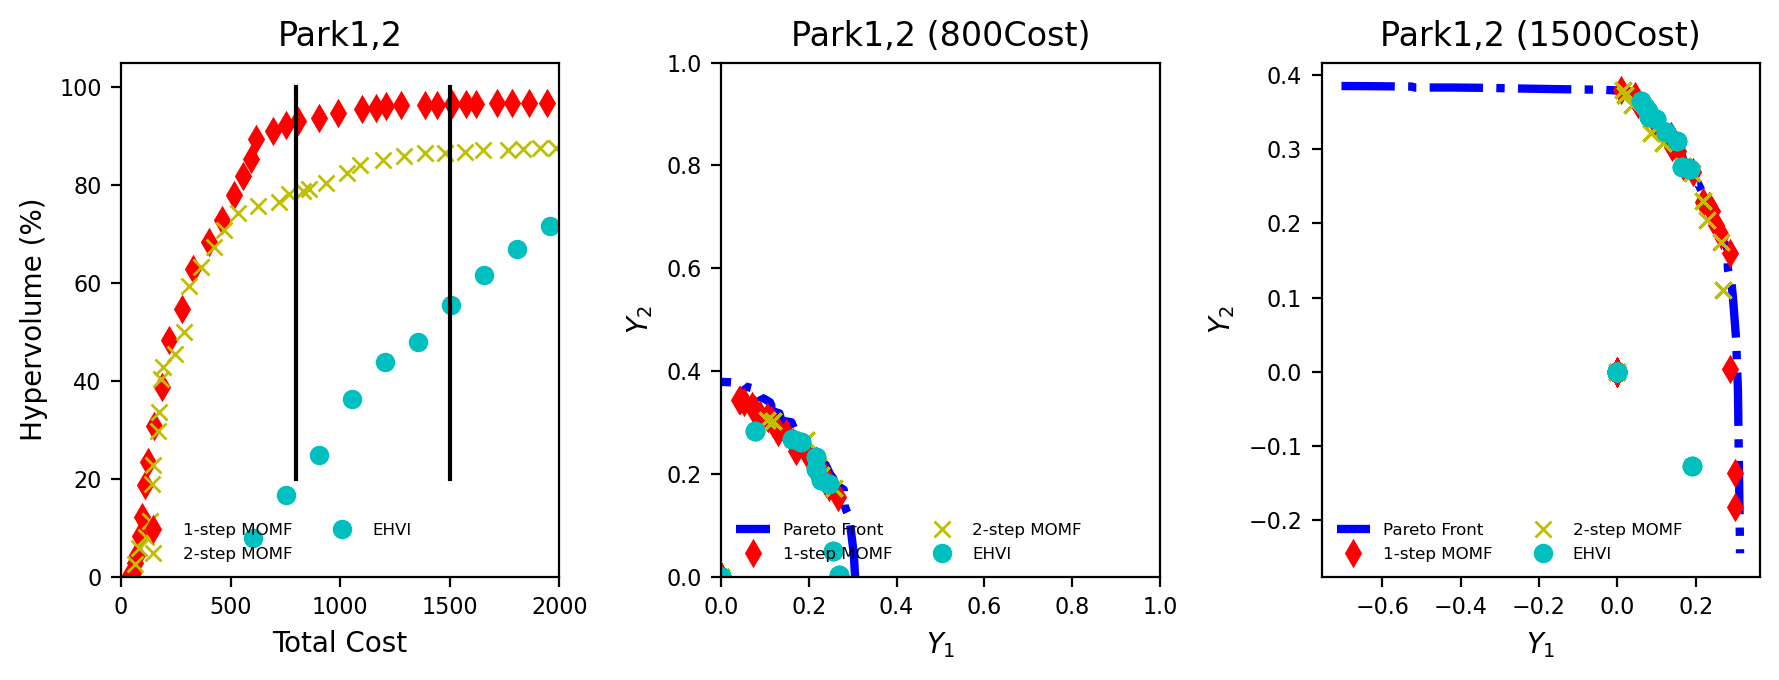

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(4,4),dpi=200)

#plt.plot(cost_MOMF[:50],hv_MOMFo[:50]/y1_volume,'o',label='Original MOMF')
axes[0].plot(np.mean(cost_MOMF[8:],axis=1),np.mean(hv_1step[:147],axis=1)/y1_volume*100,'rd',label='1-step MOMF')
axes[0].plot(np.mean(cost_MOMF2[8:],axis=1),np.mean(hv_2step[:147],axis=1)/y1_volume*100,'yx',label='2-step MOMF')
axes[0].plot(cost_MO[3:],np.mean(hv_MO[:148,:],axis=1)/y1_volume*100,'co',label='EHVI')
axes[0].plot(np.repeat(800,101),np.linspace(20,100,101),'k-')
axes[0].plot(np.repeat(1500,101),np.linspace(20,100,101),'k-')
#plt.plot(cost_MO[:-1],np.mean(hvM[:-1,:],axis=1)/y1_volume,'o',label='Removed MO')

axes[0].set_title('Park1,2',fontsize='12')
axes[0].set_xlabel('Total Cost',fontsize='10')
axes[0].set_ylabel('Hypervolume (%)',fontsize='10')
axes[0].set_xlim(0,2000)
axes[0].set_ylim(0,105)
axes[0].tick_params(labelsize=8)
axes[0].legend(loc='lower left', fontsize='6',frameon=False,ncol=2)

